# Spiral arm instability

In [1]:
import os
from IPython.display import Image
import numpy as np
from PIL import Image as Im
from astropy.utils.data import get_pkg_data_filename
from astropy.wcs import WCS
from astropy.io import fits
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
from astropy.wcs.utils import pixel_to_skycoord, skycoord_to_pixel

%pylab
%matplotlib inline
%run ./load_notebook.py

Using matplotlib backend: GTK3Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
Distance = 9.3 # Mpc
incl = 62.
cosi = np.cos(incl / 180. * np.pi)
sini = np.sin(incl / 180. * np.pi)
scale = (Distance*1000*2*np.pi)/(360*60*60.) # kpc/acrsec

In [3]:
sigma_s = np.load('./data/sigma_s.npy')
Sigma_H2 = np.load('./data/Sigma_H2.npy')
sigma_HI = np.load('./data/sigma_HI.npy')
Sigma_HI = np.load('./data/Sigma_HI.npy')
Sigma_s = np.load('./data/Sigma_s.npy')
Sigma_s_old = np.load('./data/Sigma_s_old.npy')
Sigma_SFR = np.load('./data/Sigma_SFR.npy')
sig_R_max = np.load('./data/sig_R_max.npy')
sig_R_min = np.load('./data/sig_R_min.npy')
r_HI = np.load('./data/r_HI.npy')
vel_HI = np.load('./data/vel_HI.npy')
r_HI_old = np.load('./data/r_HI_old.npy')
vel_HI_old = np.load('./data/vel_HI_old.npy')
velocity_HI = np.load('./data/velocity_HI.npy')
kappa = np.load('./data/kappa.npy')
dist_kpc = np.load('./data/dist_kpc_corr.npy')
sig_R_min_err = np.load('./data/sig_R_min_err.npy')
sig_R_max_err = np.load('./data/sig_R_max_err.npy')
sigma_s_err = np.load('./data/sigma_s_err.npy')
phi = np.load('./data/phi.npy')
mask_stars =  np.load('./data/mask_stars.npy')
mask_gas =  np.load('./data/mask_gas.npy')
width_gas = np.load('./data/width_gas.npy')
width_star = np.load('./data/width_star.npy')
Sigma_HI_peak = np.load('./data/Sigma_HI_peak.npy')
Sigma_H2_peak = np.load('./data/Sigma_H2_peak.npy')
Sigma_s_peak = np.load('./data/Sigma_s_peak.npy')

## A single-component model


$$ S = \dfrac{\sigma^2 \kappa^2 + 4 \Omega^2}{\pi G f(\kappa W) Y \kappa^2}$$



$f(\kappa W) = K_0(\kappa W) L_{-1}(\kappa W) + K_1(\kappa W) L_0(\kappa W)$

where $K_i$ and $L_i$ are modified Bessel and Struve functions of order i

$$Y = 1.4 W \Sigma_0$$
$$\sigma = \sigma_{\phi} + c$$
$\sigma_{\phi}$ and $c$ are azimuthal dispersion of turbulent velocities and sound velocity of gas.

### The instability condition issatisfied when min(S(k))<1

## A two-component model


$$ S = \dfrac{1}{\pi G \kappa^2} \left(\dfrac{f(\kappa W_g) Y_g}{\sigma_g^2 \kappa^2 + 4 \Omega_g^2} + \dfrac{f(\kappa W_s) Y_s }{\sigma_s^2 \kappa^2 + 4 \Omega_s^2} \right) ^ {-1}$$



$f(\kappa W) = K_0(\kappa W) L_{-1}(\kappa W) + K_1(\kappa W) L_0(\kappa W)$

where $K_i$ and $L_i$ are modified Bessel and Struve functions of order i

$$Y_{g,s} = 1.4 W_{g,s} \Sigma^0_{g,s}$$
$$\sigma_g = \sigma_{\phi}^g + c$$
$\sigma_{\phi}^g$ and $c$ are azimuthal dispersion of turbulent velocities and sound velocity of gas.

У нас есть данные с минимальной и максимальной радиальной дисперсией и есть соотношение $0.25\leq\dfrac{\sigma^2_{\varphi}}{\sigma^2_{R}}\leq1$
### The instability condition issatisfied when min(S(k))<1

## Газовый диск

### Поиccледум функцию $S(\kappa)$

In [4]:
 from scipy.special import k0,k1,modstruve
    

In [5]:
f = lambda y: k0(y) * modstruve(-1,y) + k1(y) * modstruve(0,y)

def Crit(sigma,x,Omega,W,Y):  
    
    return (sigma**2 * x**2 + 4 * Omega**2) / (np.pi * G * f(x*W) * Y * x**2)
    

In [6]:
k = np.linspace(0.01,100,10000)
W = 1

In [7]:
log_f = np.log10(f(k*W))

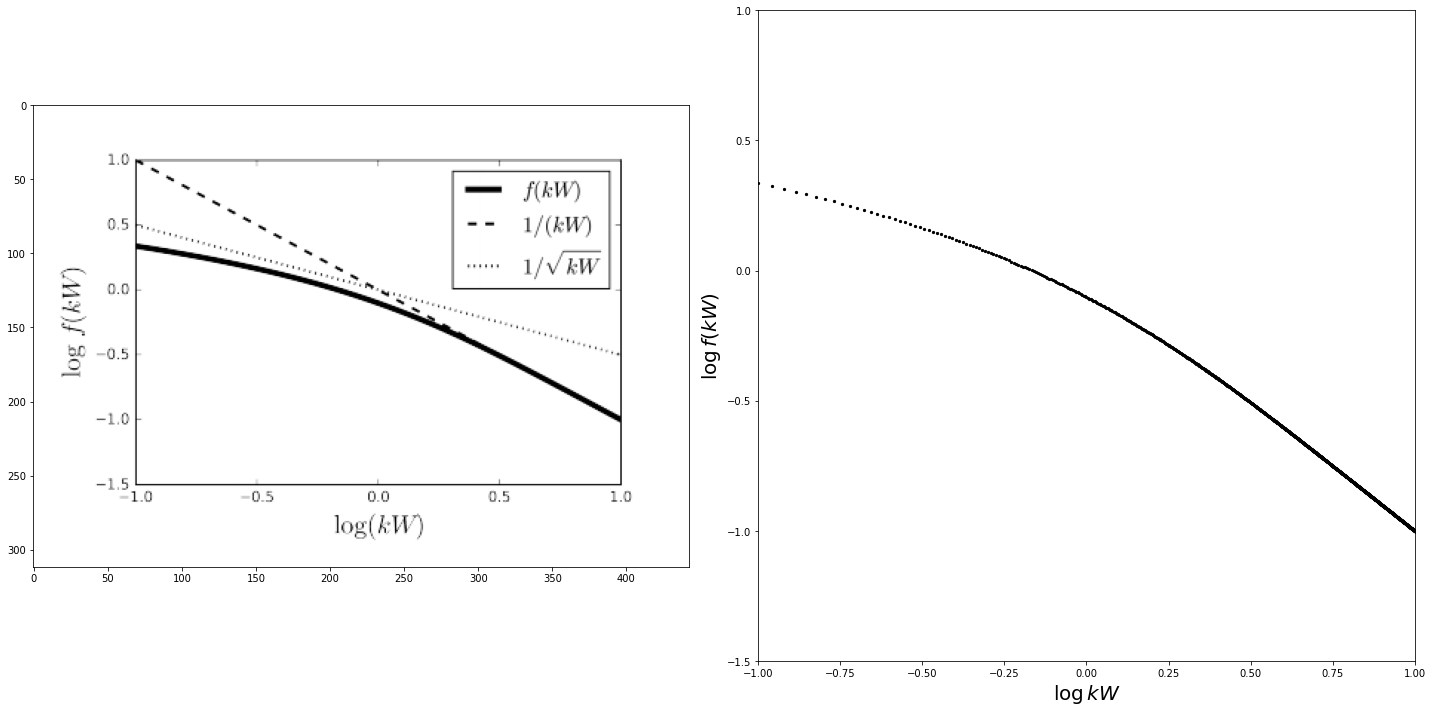

In [8]:
fig, axes = plt.subplots(1, 2,figsize=[20, 10])
axes[0].imshow(Im.open('./images/f(kW).png'))
axes[1].scatter(np.log10(k*W),log_f, 5., color='black')
axes[1].set_ylabel(r'$\log{f(kW)}$',fontsize=20)
axes[1].set_xlabel(r'$\log{kW}$',fontsize=20)
axes[1].set_ylim(-1.5,1)
axes[1].set_xlim(-1.,1.)
plt.tight_layout()
plt.show()

In [9]:
W = 0.5
Omega = 30
G = 4.32
Y = 1.4 * W * 5


In [10]:
k = np.linspace(1,100,1000)

Text(0, 0.5, 'S(k)')

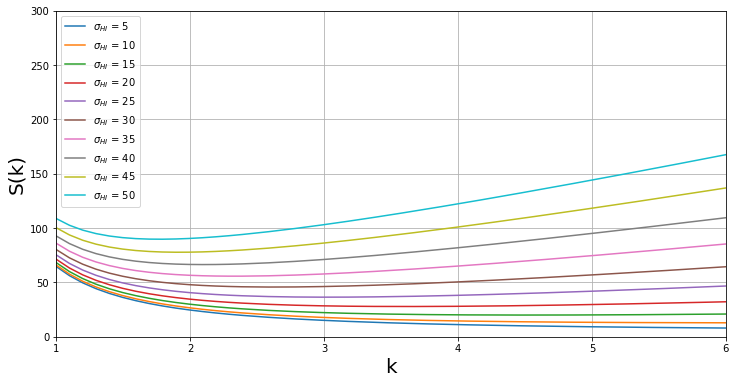

In [11]:
sigma = np.linspace(5,50,10)
plt.figure(figsize=[12, 6])
for s in sigma:
    plt.plot(k,Crit(s,k,Omega,W,Y),label = r'$\sigma_{HI}$ = '+str(int(s)))
plt.legend()
plt.grid()
plt.xlim(1.,6.)
plt.ylim(0.,300)
plt.xlabel('k', fontsize=20)
plt.ylabel('S(k)', fontsize=20)

In [12]:
W = 0.5
sigma = 20
G = 4.32
Y = 1.4 * W * 5

Text(0, 0.5, 'S(k)')

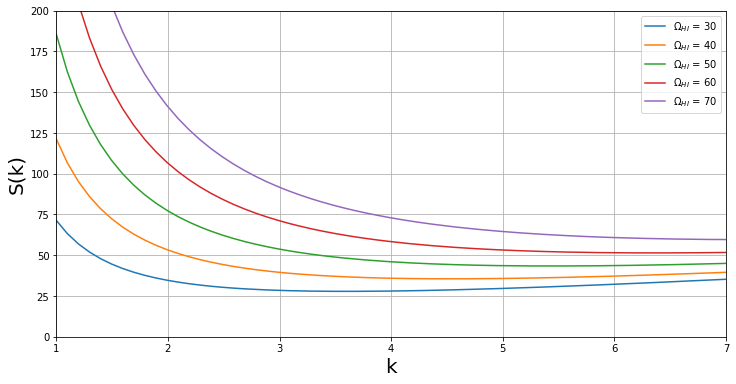

In [13]:
Omega = np.linspace(30,70,5)
plt.figure(figsize=[12, 6])
for s in Omega:
    plt.plot(k,Crit(sigma,k,s,W,Y),label = r'$\Omega_{HI}$ = '+str(int(s)))
plt.legend()
plt.grid()
plt.xlim(1.,7.)
plt.ylim(0.,200)
plt.xlabel('k', fontsize=20)
plt.ylabel('S(k)', fontsize=20)

In [14]:
Omega= 30
sigma = 20
G = 4.32


Text(0, 0.5, 'S(k)')

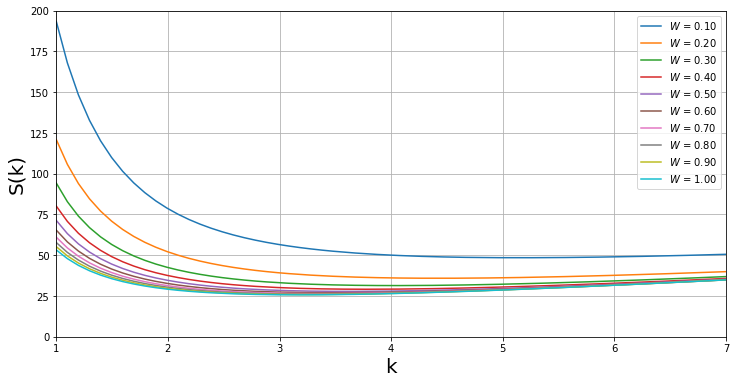

In [15]:
W = np.linspace(0.1,1,10)
plt.figure(figsize=[12, 6])
for s in W:
    plt.plot(k,Crit(sigma,k,Omega,s,1.4*s*5),label = r'$W$ = '+"%.2f"%(s))
plt.legend()
plt.grid()
plt.xlim(1.,7.)
plt.ylim(0.,200)
plt.xlabel('k', fontsize=20)
plt.ylabel('S(k)', fontsize=20)

In [16]:
Omega= 30
sigma = 20
G = 4.32
W = 0.5

Text(0, 0.5, 'S(k)')

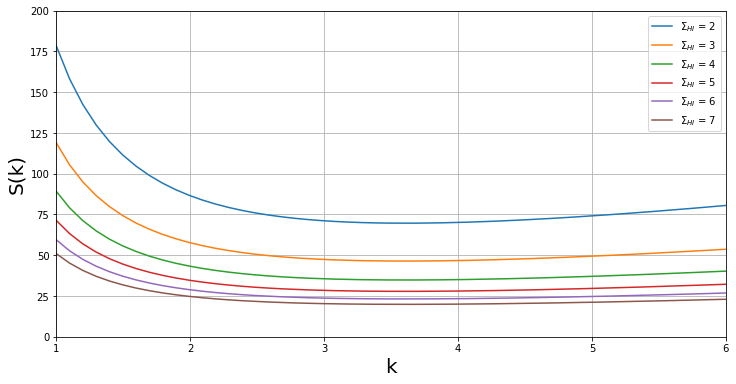

In [17]:
Gas = np.linspace(2,7,6)
plt.figure(figsize=[12, 6])
for s in Gas:
    plt.plot(k,Crit(sigma,k,Omega,W,s*1.4*W),label = r'$\Sigma_{HI}$ = '+str(int(s)))
plt.legend()
plt.grid()
plt.xlim(1.,6.)
plt.ylim(0.,200)
plt.xlabel('k', fontsize=20)
plt.ylabel('S(k)', fontsize=20)

## Новые результаты с обновленными ширинами

<ipython-input-6-917c73f88a08>:5: RuntimeWarning: divide by zero encountered in log
  quadmesh = plt.pcolormesh(X, Y, np.log(width_gas),cmap='magma')
<ipython-input-6-917c73f88a08>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  quadmesh = plt.pcolormesh(X, Y, np.log(width_gas),cmap='magma')
<ipython-input-6-917c73f88a08>:11: RuntimeWarning: divide by zero encountered in log
  quadmesh = plt.pcolormesh(X, Y,np.log(width_star), cmap='magma')
<ipython-input-6-917c73f88a08>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.s

Text(0.5, 1.0, '$\\log\\Sigma_{S}^{peak}$')

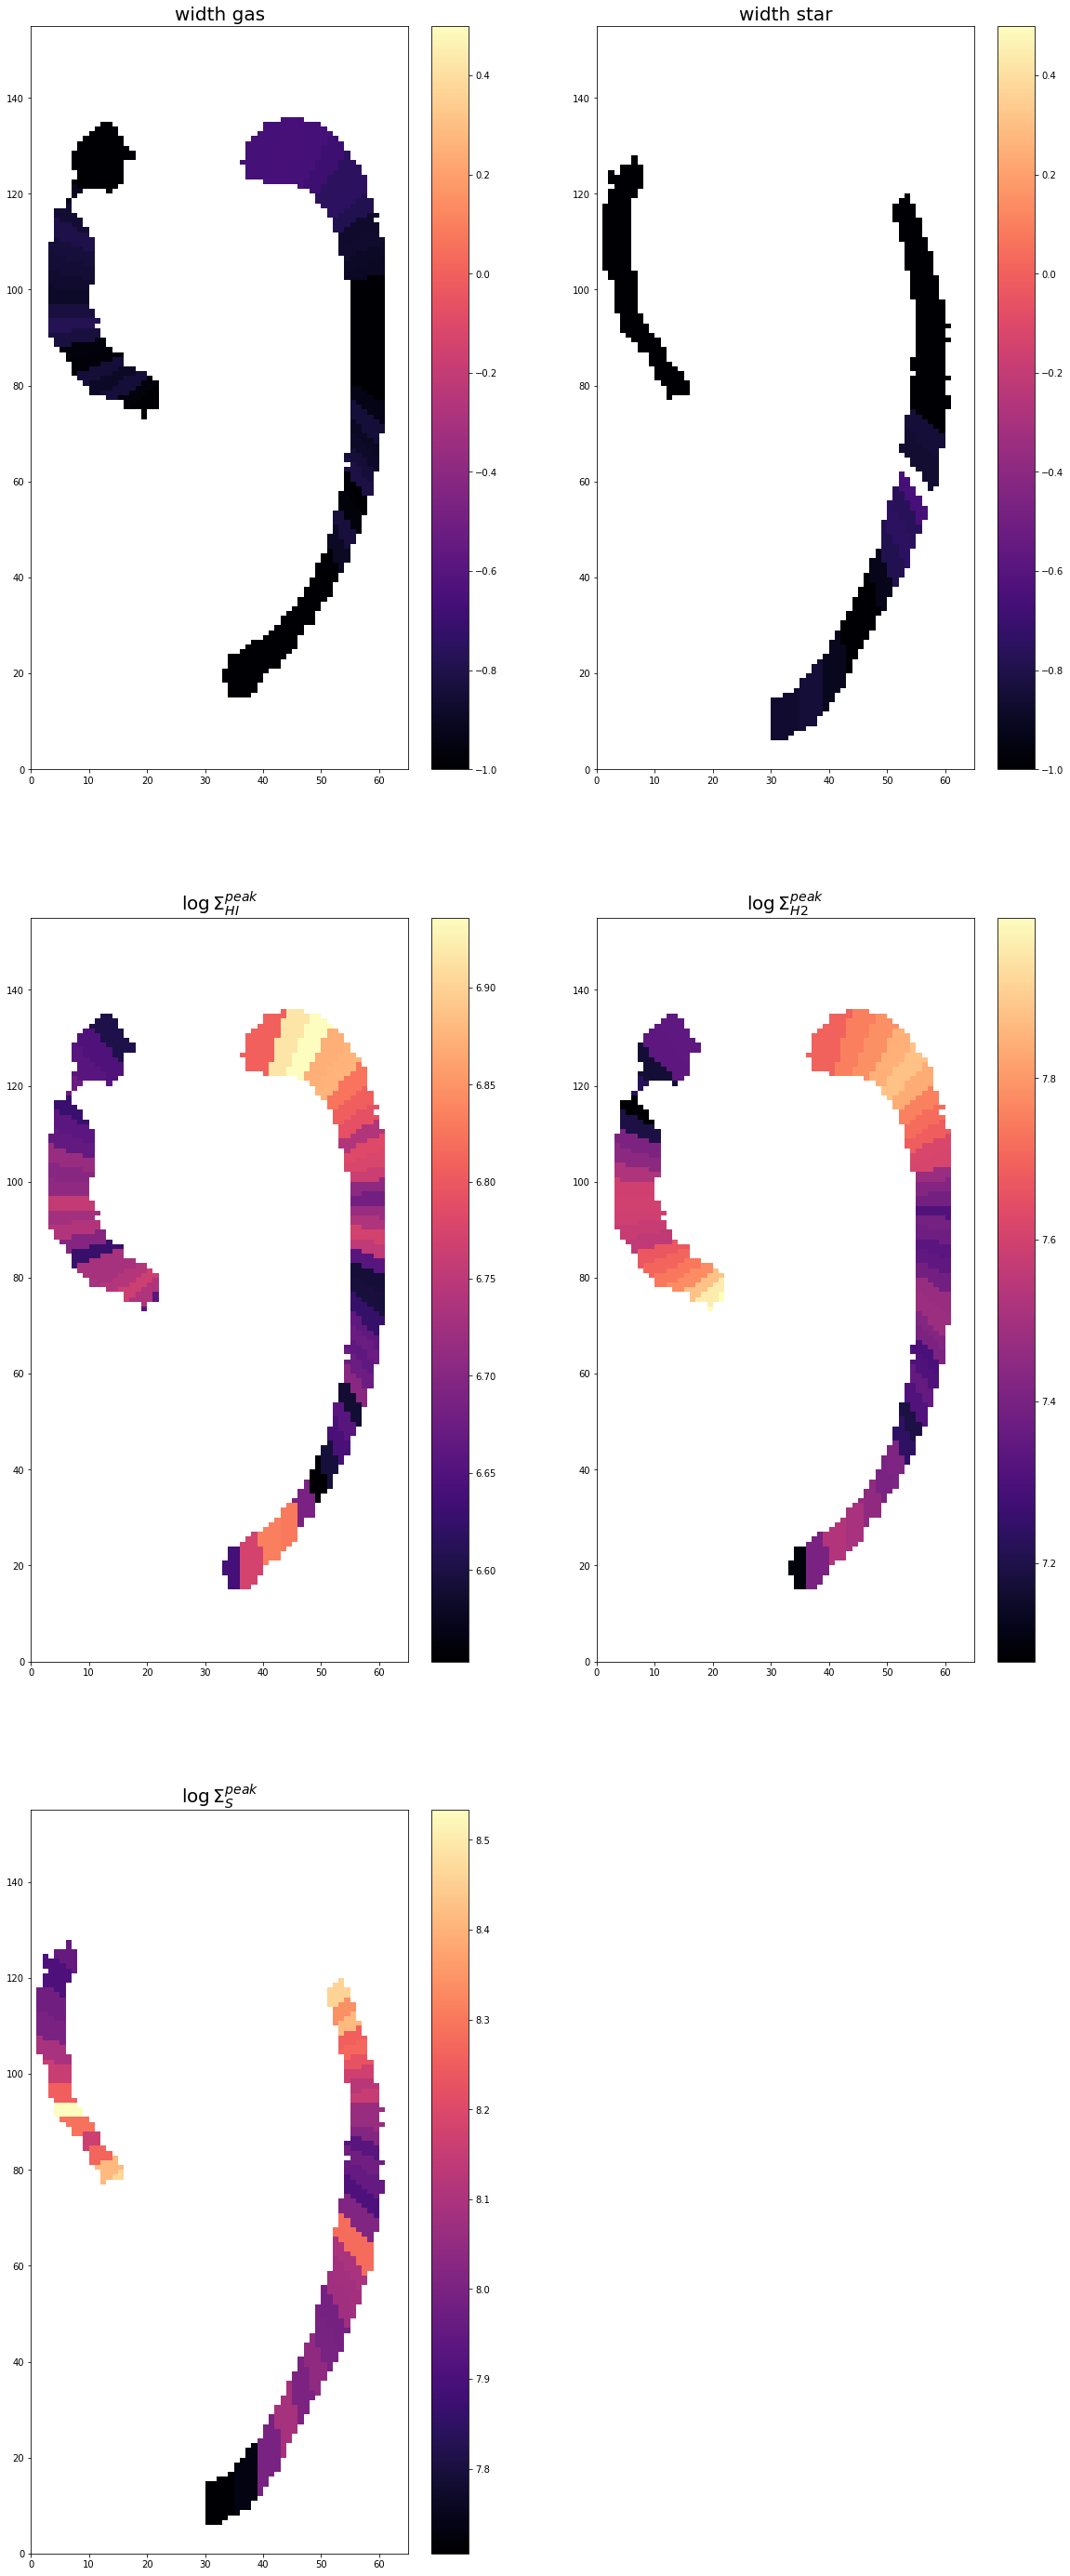

In [6]:
X,Y = np.meshgrid(np.arange(0.,66,1), np.arange(0.,156,1))

fig = plt.figure(figsize=[20,50])
plt.subplot(3,2,1)
quadmesh = plt.pcolormesh(X, Y, np.log(width_gas),cmap='magma')
quadmesh.set_clim(vmin=-1, vmax=0.5)
plt.colorbar()
plt.title(r'width gas',fontsize=20)

plt.subplot(3,2,2)
quadmesh = plt.pcolormesh(X, Y,np.log(width_star), cmap='magma')
plt.colorbar()
quadmesh.set_clim(vmin=-1, vmax=0.5)
plt.title(r'width star', fontsize=20)

plt.subplot(3,2,3)
quadmesh = plt.pcolormesh(X, Y, np.log10(Sigma_HI_peak*10**6), cmap='magma')
plt.colorbar()
#quadmesh.set_clim(vmin=6.5, vmax=8.5)
plt.title(r'$\log\Sigma_{HI}^{peak}$',fontsize=20)

plt.subplot(3,2,4)
quadmesh = plt.pcolormesh(X, Y,np.log10(Sigma_H2_peak*10**6), cmap='magma')
plt.colorbar()
#quadmesh.set_clim(vmin=6.5, vmax=8.5)
plt.title(r'$\log\Sigma_{H2}^{peak}$', fontsize=20)

plt.subplot(3,2,5)
quadmesh = plt.pcolormesh(X, Y,np.log10(Sigma_s_peak*10**6), cmap='magma')
plt.colorbar()
#quadmesh.set_clim(vmin=6.5, vmax=8.5)
plt.title(r'$\log\Sigma_{S}^{peak}$', fontsize=20)

### Посчитаем критерий для газа

In [7]:
G = 4.3
x = np.linspace(1,50,100)
inst_param_HI = np.zeros(dist_kpc.shape)
inst_param_HI[:,:] = np.nan

for i, row in enumerate(dist_kpc):
    for j, col in enumerate(dist_kpc[0]):
        
            if (mask_gas[i][j]>2.5):
                sigma_gr = sigma_HI[i][j]/1000.
                Omega = 50.
                W_gr = width_gas[i][j]
                Y_gr = 1.44 * W_gr * Sigma_HI_peak[i][j]
                S_gr = (sigma_gr**2 * x**2 + 4 * Omega**2) / (np.pi * G * f(x*W_gr) * Y_gr * x**2)
                inst_param_HI[i][j] = np.min(np.abs(S_gr))
                
            if (mask_gas[i][j]==1.):
                sigma_r = sigma_HI[i][j]/1000.
                Omega = 50.
                W_r = width_gas[i][j]
                Y_r = 1.44 * W_r * Sigma_HI_peak[i][j]
                S_r = (sigma_r**2 * x**2 + 4 * Omega**2) / (np.pi * G * f(x*W_r) * Y_r * x**2)
                inst_param_HI[i][j] = np.min(S_r) 

<ipython-input-5-7817e7e8d27f>:1: RuntimeWarning: invalid value encountered in multiply
  f = lambda y: k0(y) * modstruve(-1,y) + k1(y) * modstruve(0,y)


<ipython-input-8-8c37956ad854>:7: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("magma").copy()
  quadmesh.cmap.set_under('white')


Text(0.5, 1.0, 'Spiral-arm criterium for gas disk (HI)')

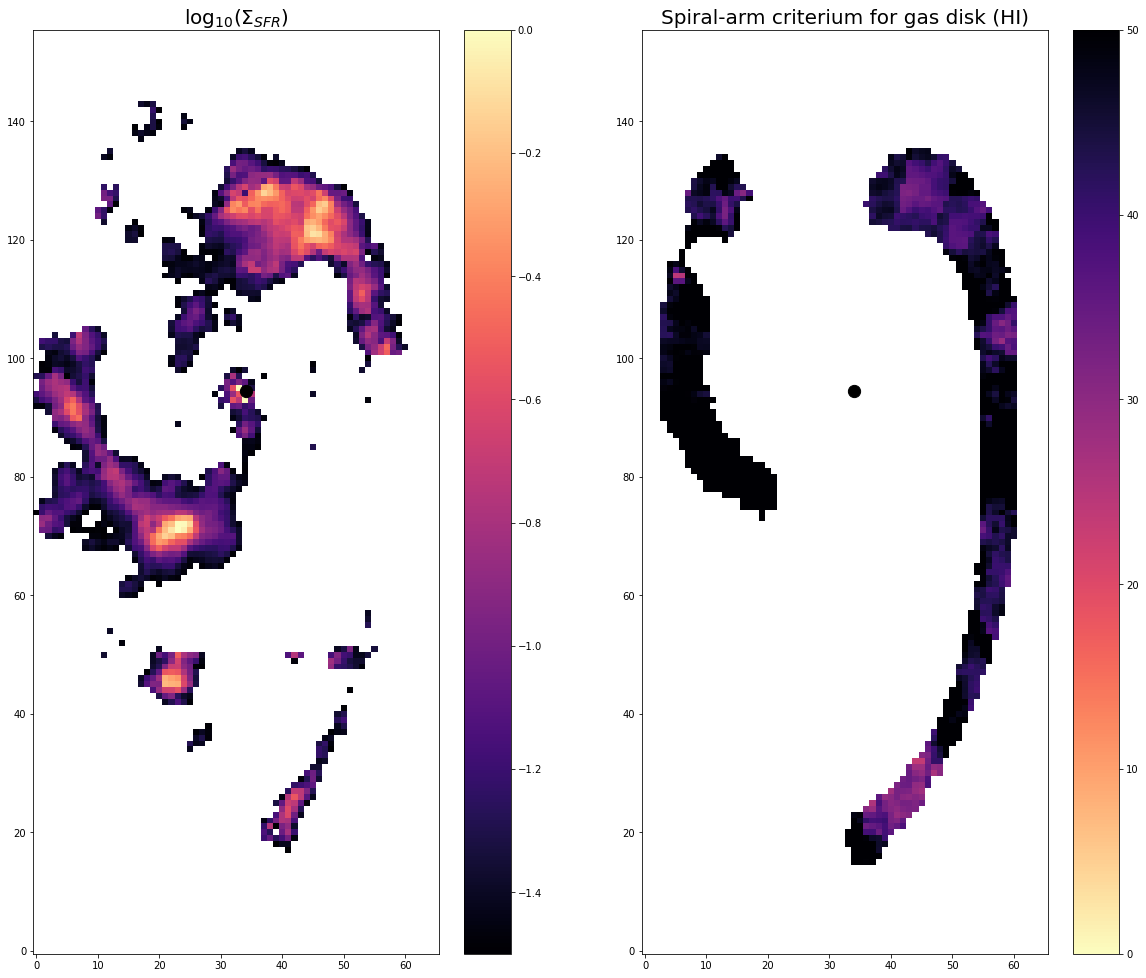

In [8]:
X,Y = np.meshgrid(np.arange(0.,66,1), np.arange(0.,156,1))

fig = plt.figure(figsize=[20,17])
plt.subplot(1,2,1)
quadmesh = plt.pcolormesh(X, Y, np.log10(Sigma_SFR),shading='auto',  cmap='magma')
quadmesh.set_clim(vmin=-1.5, vmax=0)
quadmesh.cmap.set_under('white')
plt.colorbar()
plt.scatter(34.06509169 ,94.54027961,[150.], color='black' )
plt.title(r'$\log_{10}(\Sigma_{SFR})$',fontsize=20)

plt.subplot(1,2,2)
quadmesh = plt.pcolormesh(X, Y,inst_param_HI, shading='auto', cmap='magma_r')
quadmesh.set_clim(vmin=0., vmax = 50.)
plt.colorbar()
plt.scatter(34.06509169 ,94.54027961,[150.], color='black' )
plt.title(r'Spiral-arm criterium for gas disk (HI)', fontsize=20)

In [9]:
x = np.linspace(1,50,100)
inst_param_H2 = np.zeros(dist_kpc.shape)
inst_param_H2[:,:] = np.nan

for i, row in enumerate(dist_kpc):
    for j, col in enumerate(dist_kpc[0]):
        
            if (mask_gas[i][j]>2.5):
                sigma_gr = sigma_HI[i][j]/1000.
                Omega = 50.
                W_gr = width_gas[i][j]
                Y_gr = 1.44 * W_gr * Sigma_H2_peak[i][j]
                S_gr = (sigma_gr**2 * x**2 + 4 * Omega**2) / (np.pi * G * f(x*W_gr) * Y_gr * x**2)
                inst_param_H2[i][j] = np.min(np.abs(S_gr))
                
            if (mask_gas[i][j]==1.):
                sigma_r = sigma_HI[i][j]/1000.
                Omega = 50.
                W_r = width_gas[i][j]
                Y_r = 1.44 * W_r * Sigma_H2_peak[i][j]
                S_r = (sigma_r**2 * x**2 + 4 * Omega**2) / (np.pi * G * f(x*W_r) * Y_r * x**2)
                inst_param_H2[i][j] = np.min(S_r) 

<ipython-input-5-7817e7e8d27f>:1: RuntimeWarning: invalid value encountered in multiply
  f = lambda y: k0(y) * modstruve(-1,y) + k1(y) * modstruve(0,y)


<ipython-input-10-10e3daa0b90e>:7: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("magma").copy()
  quadmesh.cmap.set_under('white')


Text(0.5, 1.0, 'Spiral-arm criterium for gas disk (H2)')

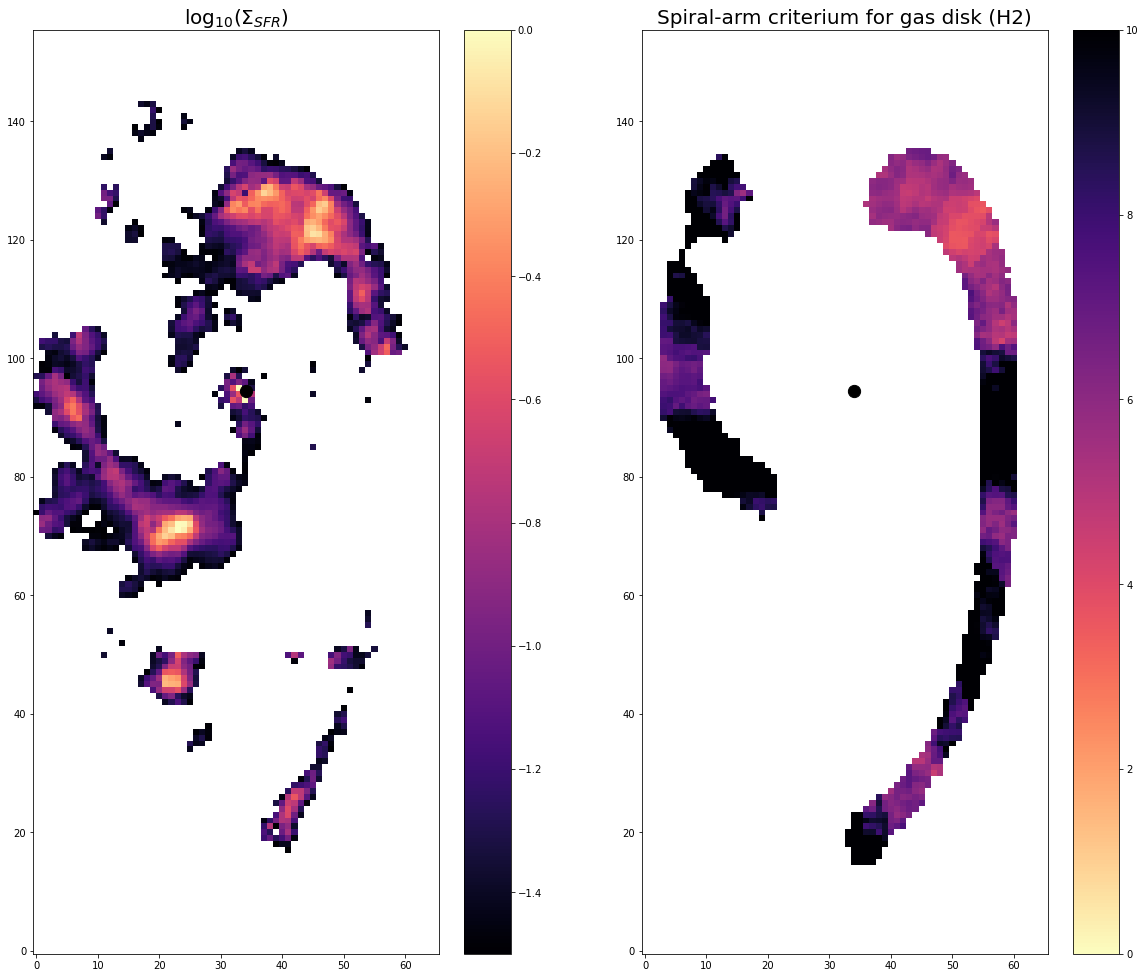

In [10]:
X,Y = np.meshgrid(np.arange(0.,66,1), np.arange(0.,156,1))

fig = plt.figure(figsize=[20,17])
plt.subplot(1,2,1)
quadmesh = plt.pcolormesh(X, Y, np.log10(Sigma_SFR),shading='auto', cmap='magma')
quadmesh.set_clim(vmin=-1.5, vmax=0)
quadmesh.cmap.set_under('white')
plt.colorbar()
plt.scatter(34.06509169 ,94.54027961,[150.], color='black' )
plt.title(r'$\log_{10}(\Sigma_{SFR})$',fontsize=20)

plt.subplot(1,2,2)
quadmesh = plt.pcolormesh(X, Y,inst_param_H2,shading='auto',cmap='magma_r')
quadmesh.set_clim(vmin=0., vmax = 10.)
plt.colorbar()
plt.scatter(34.06509169 ,94.54027961,[150.], color='black' )
plt.title(r'Spiral-arm criterium for gas disk (H2)', fontsize=20)

### Посчитаем критерий для звезд

In [51]:
x = np.linspace(1,50,100)
inst_param_star_min = np.zeros(dist_kpc.shape)
inst_param_star_min[:,:] = np.nan

for i, row in enumerate(dist_kpc):
    for j, col in enumerate(dist_kpc[0]):
        
            if (mask_stars[i][j]>2.5):
                sigma_ = sig_R_min[i][j]*0.25
                Omega = 50.
                W_ = width_star[i][j]
                Y_ = 1.44 * W_gr * Sigma_s_peak[i][j]
                S_ = (sigma_**2 * x**2 + 4 * Omega**2) / (np.pi * G * f(x*W_) * Y_ * x**2)
                inst_param_star_min[i][j] = np.min(S_)
           
        
inst_param_star_max = np.zeros(dist_kpc.shape)
inst_param_star_max[:,:] = np.nan

for i, row in enumerate(dist_kpc):
    for j, col in enumerate(dist_kpc[0]):
        
            if (mask_stars[i][j]>2.5):
                sigma_ = sig_R_max[i][j]
                Omega = 50.
                W_ = width_star[i][j]
                Y_ = 1.44 * W_gr * Sigma_s_peak[i][j]
                S_ = (sigma_**2 * x**2 + 4 * Omega**2) / (np.pi * G * f(x*W_) * Y_ * x**2)
                inst_param_star_max[i][j] = np.min(S_)        

<ipython-input-5-7817e7e8d27f>:1: RuntimeWarning: invalid value encountered in multiply
  f = lambda y: k0(y) * modstruve(-1,y) + k1(y) * modstruve(0,y)


Text(0.5, 1.0, 'Spiral-arm criterium for stellar component $\\sigma_{phi}^{max}$')

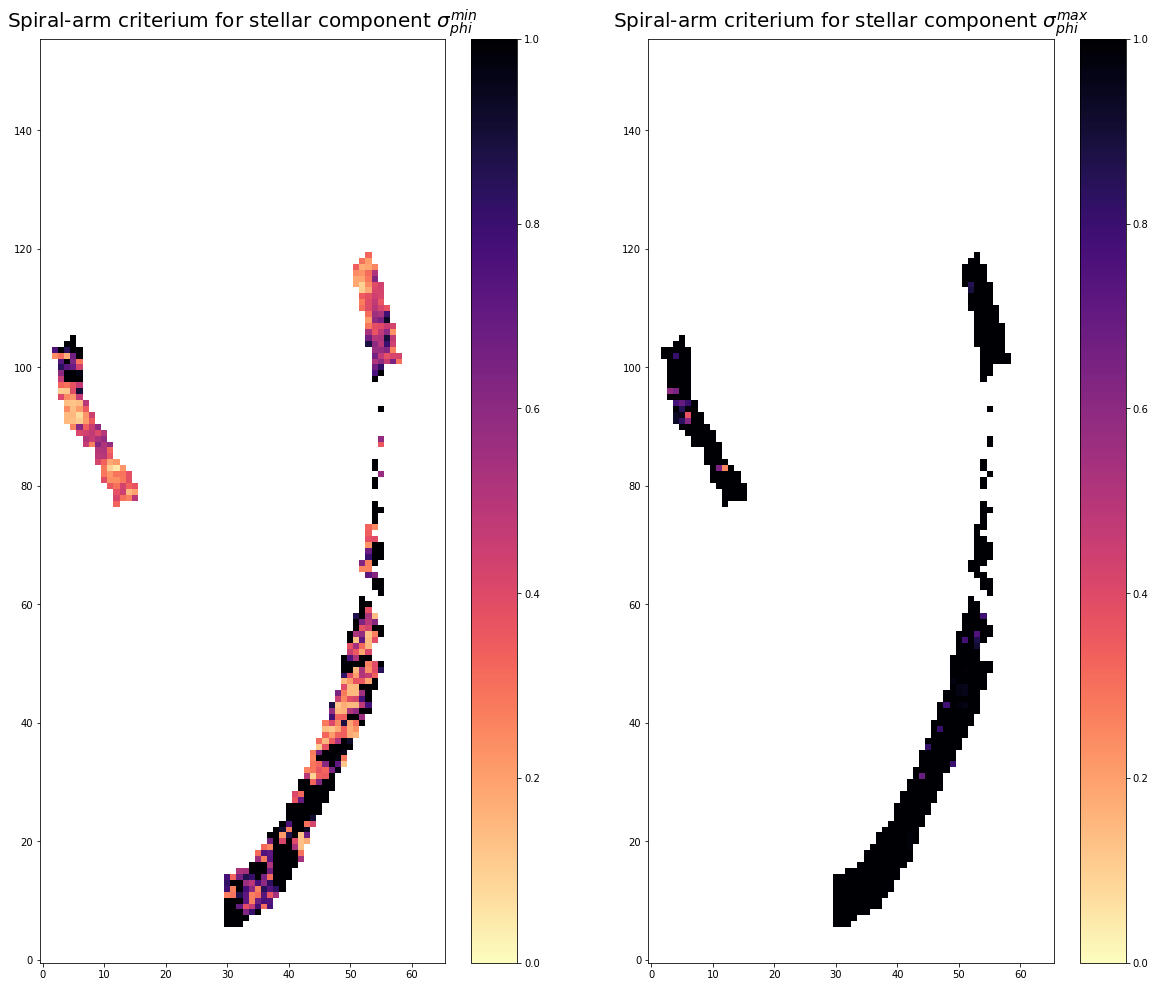

In [55]:
X,Y = np.meshgrid(np.arange(0.,66,1), np.arange(0.,156,1))

fig = plt.figure(figsize=[20,17])
plt.subplot(1,2,1)
quadmesh = plt.pcolormesh(X, Y,inst_param_star_min,shading='auto', cmap='magma_r')
quadmesh.set_clim(vmin=0., vmax=1.)
plt.colorbar()
plt.title(r'Spiral-arm criterium for stellar component $\sigma_{phi}^{min}$', fontsize=20)

plt.subplot(1,2,2)
quadmesh = plt.pcolormesh(X, Y,inst_param_star_max,shading='auto', cmap='magma_r')
quadmesh.set_clim(vmin=0., vmax=1.)
plt.colorbar()
plt.title(r'Spiral-arm criterium for stellar component $\sigma_{phi}^{max}$', fontsize=20)

### Посчитаем критерий для трехкомпонентной неустойчивости на спиралях

In [56]:
sigma_s = np.nan_to_num(sigma_s)
x = np.linspace(1,50,100)
inst_param_full_min = np.zeros(dist_kpc.shape)
inst_param_full_min[:,:] = np.nan

for i, row in enumerate(dist_kpc):
    for j, col in enumerate(dist_kpc[0]):
        
        if (mask_gas[i][j]>0.5) & (mask_stars[i][j]>2.5) & (sigma_s[i][j] != 0):
                sigma_star = sig_R_min[i][j]*0.25
                sigma_gas= sigma_HI[i][j]/1000.
                Omega = 50.
                W_g = width_gas[i][j]
                W_s = width_star[i][j]
                Y_HI = 1.44 * W_g * Sigma_HI_peak[i][j]
                Y_H2 = 1.44 * W_g * Sigma_H2_peak[i][j]
                Y_s = 1.44 * W_s * Sigma_s_peak[i][j]
                S_ = 1./(np.pi*G*x**2 * (  (Y_HI * f(x*W_g))/(sigma_gas**2*x**2 + 4*Omega**2) +
                                           (Y_H2 * f(x*W_g))/(sigma_gas**2*x**2 + 4*Omega**2) +
                                           (Y_s * f(x*W_s))/(sigma_star**2*x**2 + 4*Omega**2) ))
                inst_param_full_min[i][j] = np.min(S_)
                
        elif (mask_gas[i][j]>0.5) & (mask_stars[i][j]<2.5):
                sigma_gas= sigma_HI[i][j]/1000.
                Omega = 50.
                W_g = width_gas[i][j]
                Y_HI = 1.44 * W_g * Sigma_HI_peak[i][j]
                Y_H2 = 1.44 * W_g * Sigma_H2_peak[i][j]
                S_ = 1./(np.pi*G*x**2 * (  (Y_HI * f(x*W_g))/(sigma_gas**2*x**2 + 4*Omega**2) +
                                           (Y_H2 * f(x*W_g))/(sigma_gas**2*x**2 + 4*Omega**2)))
                inst_param_full_min[i][j] = np.min(S_)
         
        elif (mask_gas[i][j]>0.5) & (sigma_s[i][j] == 0):
                sigma_gas= sigma_HI[i][j]/1000.
                Omega = 50.
                W_g = width_gas[i][j]
                Y_HI = 1.44 * W_g * Sigma_HI_peak[i][j]
                Y_H2 = 1.44 * W_g * Sigma_H2_peak[i][j]
                S_ = 1./(np.pi*G*x**2 * (  (Y_HI * f(x*W_g))/(sigma_gas**2*x**2 + 4*Omega**2) +
                                           (Y_H2 * f(x*W_g))/(sigma_gas**2*x**2 + 4*Omega**2)))
                inst_param_full_min[i][j] = np.min(S_)
                
        elif (mask_gas[i][j]<0.5) & (mask_stars[i][j]>2.5) & (sigma_s[i][j] != 0):
                sigma_star = sig_R_min[i][j]*0.25
                Omega = 50.
                W_s = width_star[i][j]
                Y_s = 1.44 * W_s * Sigma_s_peak[i][j]
                S_ = 1./(np.pi*G*x**2 * ( (Y_s * f(x*W_s))/(sigma_star**2*x**2 + 4*Omega**2) ))
                inst_param_full_min[i][j] = np.min(S_)        
       

<ipython-input-5-7817e7e8d27f>:1: RuntimeWarning: invalid value encountered in multiply
  f = lambda y: k0(y) * modstruve(-1,y) + k1(y) * modstruve(0,y)


In [57]:
x = np.linspace(1,50,100)
inst_param_full_max = np.zeros(dist_kpc.shape)
inst_param_full_max[:,:] = np.nan

for i, row in enumerate(dist_kpc):
    for j, col in enumerate(dist_kpc[0]):
        
        if (mask_gas[i][j]>0.5) & (mask_stars[i][j]>2.5) & (sigma_s[i][j] != 0):
                sigma_star = sig_R_max[i][j]
                sigma_gas= sigma_HI[i][j]/1000.
                Omega = 50.
                W_g = width_gas[i][j]
                W_s = width_star[i][j]
                Y_HI = 1.44 * W_g * Sigma_HI_peak[i][j]
                Y_H2 = 1.44 * W_g * Sigma_H2_peak[i][j]
                Y_s = 1.44 * W_s * Sigma_s_peak[i][j]
                S_ = 1./(np.pi*G*x**2 * (  (Y_HI * f(x*W_g))/(sigma_gas**2*x**2 + 4*Omega**2) +
                                           (Y_H2 * f(x*W_g))/(sigma_gas**2*x**2 + 4*Omega**2) +
                                           (Y_s * f(x*W_s))/(sigma_star**2*x**2 + 4*Omega**2) ))
                inst_param_full_max[i][j] = np.min(S_)
                
        elif (mask_gas[i][j]>0.5) & (mask_stars[i][j]<2.5):
                sigma_gas= sigma_HI[i][j]/1000.
                Omega = 50.
                W_g = width_gas[i][j]
                Y_HI = 1.44 * W_g * Sigma_HI_peak[i][j]
                Y_H2 = 1.44 * W_g * Sigma_H2_peak[i][j]
                S_ = 1./(np.pi*G*x**2 * (  (Y_HI * f(x*W_g))/(sigma_gas**2*x**2 + 4*Omega**2) +
                                           (Y_H2 * f(x*W_g))/(sigma_gas**2*x**2 + 4*Omega**2)))
                inst_param_full_max[i][j] = np.min(S_)
         
        elif (mask_gas[i][j]>0.5) & (sigma_s[i][j] == 0):
                sigma_gas= sigma_HI[i][j]/1000.
                Omega = 50.
                W_g = width_gas[i][j]
                Y_HI = 1.44 * W_g * Sigma_HI_peak[i][j]
                Y_H2 = 1.44 * W_g * Sigma_H2_peak[i][j]
                S_ = 1./(np.pi*G*x**2 * (  (Y_HI * f(x*W_g))/(sigma_gas**2*x**2 + 4*Omega**2) +
                                           (Y_H2 * f(x*W_g))/(sigma_gas**2*x**2 + 4*Omega**2)))
                inst_param_full_max[i][j] = np.min(S_)
                
        elif (mask_gas[i][j]<0.5) & (mask_stars[i][j]>2.5) & (sigma_s[i][j] != 0):
                sigma_star = sig_R_max[i][j]
                Omega = 50.
                W_s = width_star[i][j]
                Y_s = 1.44 * W_s * Sigma_s_peak[i][j]
                S_ = 1./(np.pi*G*x**2 * ( (Y_s * f(x*W_s))/(sigma_star**2*x**2 + 4*Omega**2) ))
                inst_param_full_max[i][j] = np.min(S_)  

<ipython-input-5-7817e7e8d27f>:1: RuntimeWarning: invalid value encountered in multiply
  f = lambda y: k0(y) * modstruve(-1,y) + k1(y) * modstruve(0,y)


Text(0.5, 1.0, 'Spiral-arm criterium for stellar+gas components $\\sigma_{phi}^{max}$')

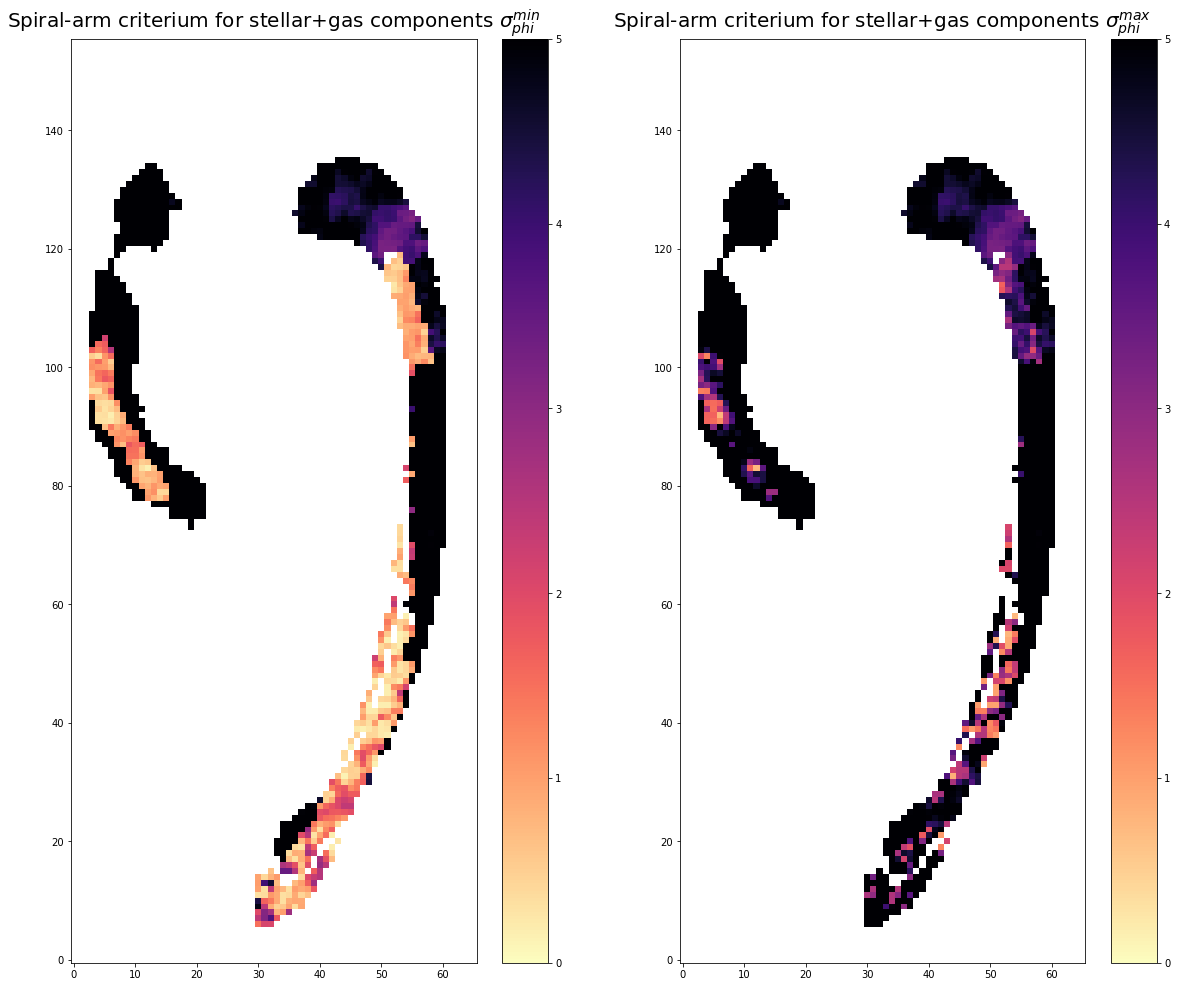

In [58]:
X,Y = np.meshgrid(np.arange(0.,66,1), np.arange(0.,156,1))

fig = plt.figure(figsize=[20,17])
plt.subplot(1,2,1)
quadmesh = plt.pcolormesh(X, Y,inst_param_full_min,shading='auto', cmap='magma_r')
quadmesh.set_clim(vmin=0., vmax=5.)
plt.colorbar()
plt.title(r'Spiral-arm criterium for stellar+gas components $\sigma_{phi}^{min}$', fontsize=20)

plt.subplot(1,2,2)
quadmesh = plt.pcolormesh(X, Y,inst_param_full_max,shading='auto', cmap='magma_r')
quadmesh.set_clim(vmin=0., vmax=5.)
plt.colorbar()
plt.title(r'Spiral-arm criterium for stellar+gas components $\sigma_{phi}^{max}$', fontsize=20)

Text(0.5, 1.0, 'Spiral-arm criterium for stellar+gas components')

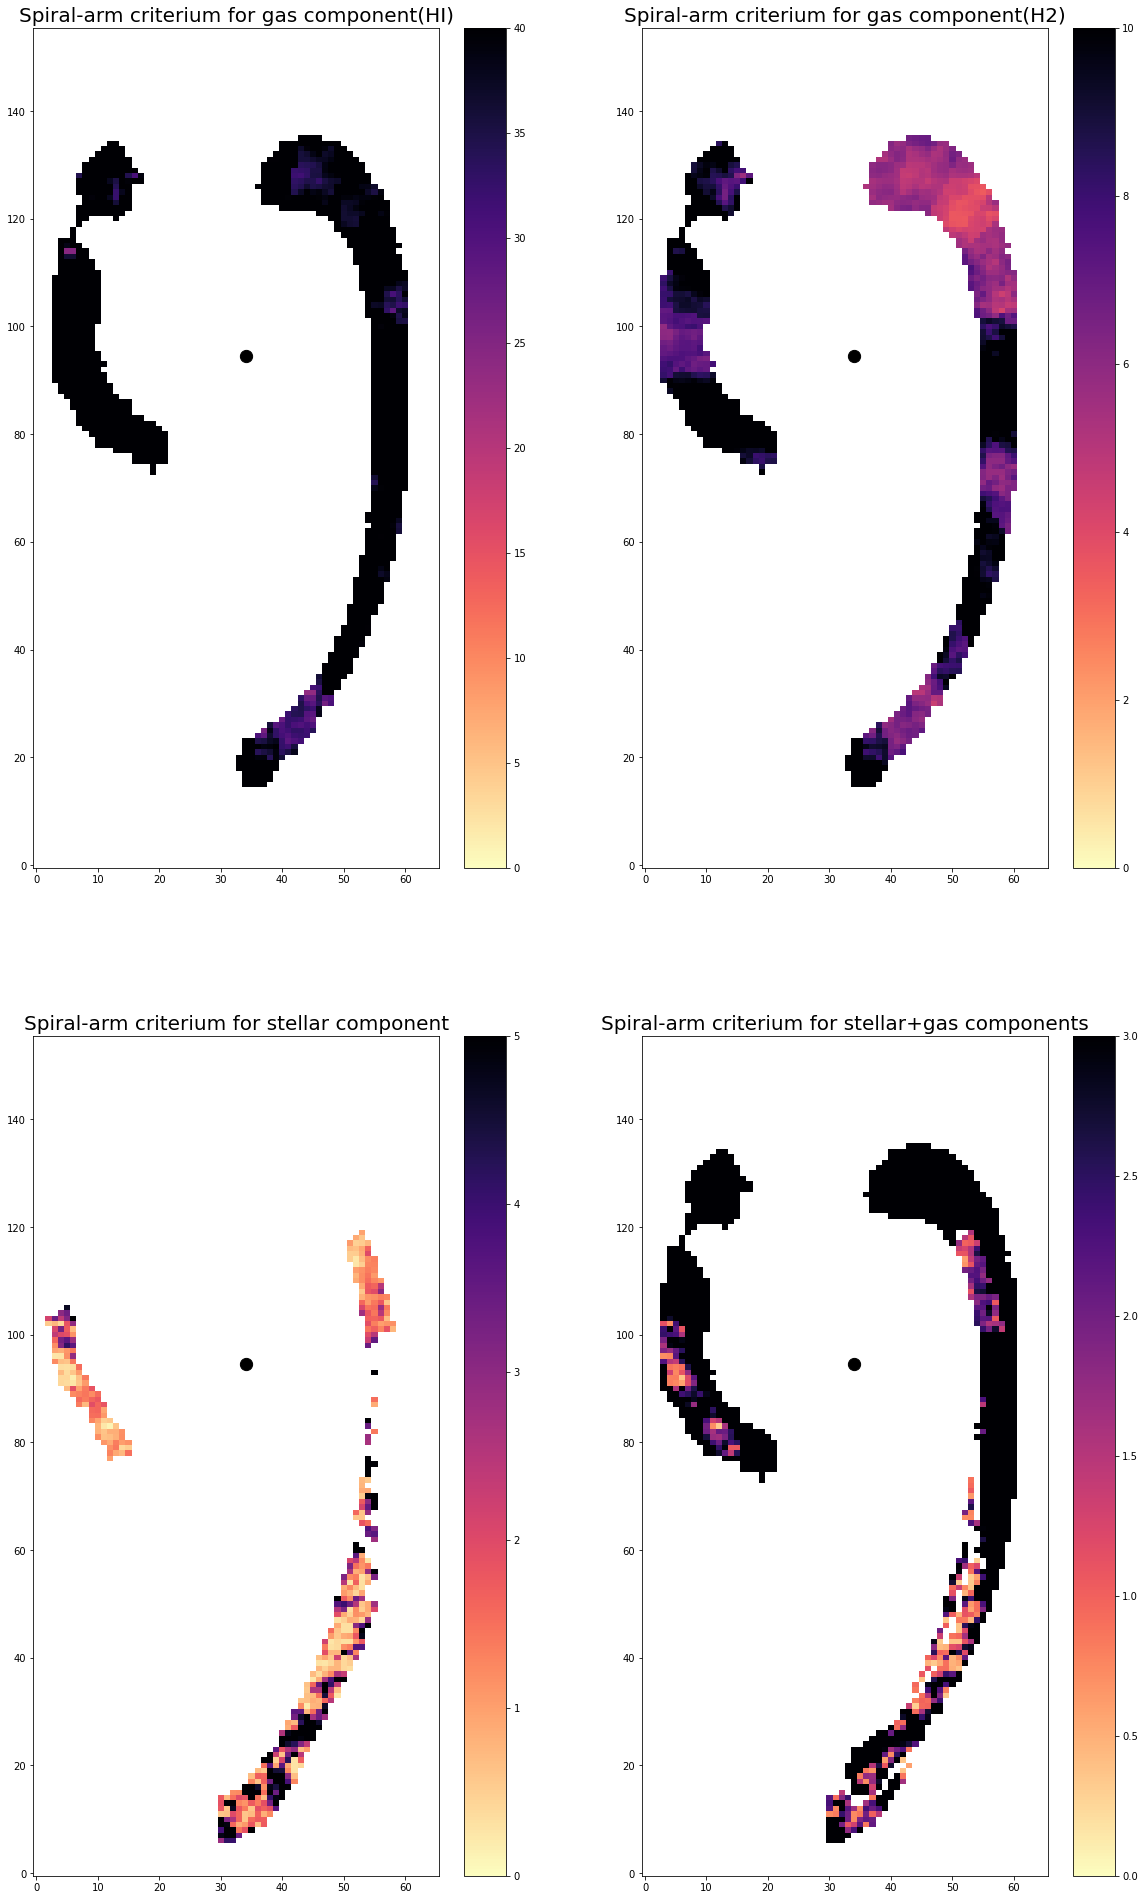

In [15]:
X,Y = np.meshgrid(np.arange(0.,66,1), np.arange(0.,156,1))

fig = plt.figure(figsize=[20,34])
plt.subplot(2,2,1)
quadmesh = plt.pcolormesh(X, Y,inst_param_HI,shading='auto', cmap='magma_r')
quadmesh.set_clim(vmin=0., vmax=40.)
plt.colorbar()
plt.scatter(34.06509169 ,94.54027961,[150.], color='black' )
plt.title(r'Spiral-arm criterium for gas component(HI)', fontsize=20)

plt.subplot(2,2,2)
quadmesh = plt.pcolormesh(X, Y,inst_param_H2,shading='auto', cmap='magma_r')
quadmesh.set_clim(vmin=0., vmax=10.)
plt.colorbar()
plt.scatter(34.06509169 ,94.54027961,[150.], color='black' )
plt.title(r'Spiral-arm criterium for gas component(H2)', fontsize=20)

plt.subplot(2,2,3)
quadmesh = plt.pcolormesh(X, Y,inst_param_star,shading='auto', cmap='magma_r')
quadmesh.set_clim(vmin=0., vmax=5.)
plt.colorbar()
plt.scatter(34.06509169 ,94.54027961,[150.], color='black' )
plt.title(r'Spiral-arm criterium for stellar component', fontsize=20)

plt.subplot(2,2,4)
quadmesh = plt.pcolormesh(X, Y,inst_param_full,shading='auto', cmap='magma_r')
quadmesh.set_clim(vmin=0., vmax=3.)
plt.colorbar()
plt.scatter(34.06509169 ,94.54027961,[150.], color='black' )
plt.title(r'Spiral-arm criterium for stellar+gas components', fontsize=20)

In [16]:
def angles(V1,U1,V2,U2,V3,U3):
    c = (V3-V1)**2 + (U3-U1)**2
    a = (V2-V1)**2 + (U2-U1)**2
    b = (V3-V2)**2 + (U3-U2)**2
    
    cos = (c-a-b)  / 2 / np.sqrt(a) / np.sqrt(b)
    res =  np.arccos(cos)
    
    if (V1-V2)*(U3-U2) - (U1-U2)*(V3-V2) < 0:
        res = 2*pi - res
    
    return res

In [17]:
phi_ = np.zeros(dist_kpc.shape)

for j, row in enumerate(dist_kpc):
    for i, col in enumerate(dist_kpc[0]):
 
        phi_[j][i] = angles(i,j,34.06509169 ,94.54027961,10.,0.)*180./np.pi
    

In [18]:
phi_array = np.linspace(0.,360.,360)
dist_array = np.linspace(1.5,6.5,120)

maps_width = np.zeros((120,360)) 

for j,angle in enumerate(phi_array):

    for i,d in enumerate(dist_array):
        value = []      
        mask = (angle-1.2 <= phi_) & (phi_ <= angle+1.2 ) & (d-0.05 <= dist_kpc) & (dist_kpc <= d+0.05)
        value = np.ravel(width_gas[mask])
        if (len(value) != 0):
            maps_width[i][j] = np.max(value)
        else:
            maps_width[i][j] = 0. 
        
       

In [19]:
maps_width_st = np.zeros((120,360)) 

for j,angle in enumerate(phi_array):

    for i,d in enumerate(dist_array):
        value = []      
        mask = (angle-1.2 <= phi_) & (phi_ <= angle+1.2 ) & (d-0.05 <= dist_kpc) & (dist_kpc <= d+0.05)
        value = np.ravel(width_star[mask])
        if (len(value) != 0):
            maps_width_st[i][j] = np.max(value)
        else:
            maps_width_st[i][j] = 0. 

In [20]:
maps_HI = np.zeros((120,360)) 

for j,angle in enumerate(phi_array):

    for i,d in enumerate(dist_array):
        value = []      
        mask = (angle-1.2 <= phi_) & (phi_ <= angle+1.2 ) & (d-0.05 <= dist_kpc) & (dist_kpc <= d+0.05)
        value = np.ravel(Sigma_HI[mask])
        if (len(value) != 0):
            maps_HI[i][j] = np.mean(value)
        else:
            maps_HI[i][j] = 0.1 

In [21]:
maps_H2 = np.zeros((120,360)) 

for j,angle in enumerate(phi_array):

    for i,d in enumerate(dist_array):
        value = []      
        mask = (angle-1.2 <= phi_) & (phi_ <= angle+1.2 ) & (d-0.05 <= dist_kpc) & (dist_kpc <= d+0.05)
        value = np.ravel(Sigma_H2[mask])
        if (len(value) != 0):
            maps_H2[i][j] = np.mean(np.abs(value))
        else:
            maps_H2[i][j] = 2. 

In [22]:
maps_star = np.zeros((120,360)) 

for j,angle in enumerate(phi_array):

    for i,d in enumerate(dist_array):
        value = []      
        mask = (angle-1.3 <= phi_) & (phi_ <= angle+1.3 ) & (d-0.05 <= dist_kpc) & (dist_kpc <= d+0.05)
        value = np.ravel(Sigma_s[mask])
        if (len(value) != 0):
            maps_star[i][j] = np.mean(value)
        else:
            maps_star[i][j] = 10. 

<ipython-input-37-988aca5bc5cd>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axes[1]= plt.pcolormesh(X,Y, maps_width,cmap='inferno')


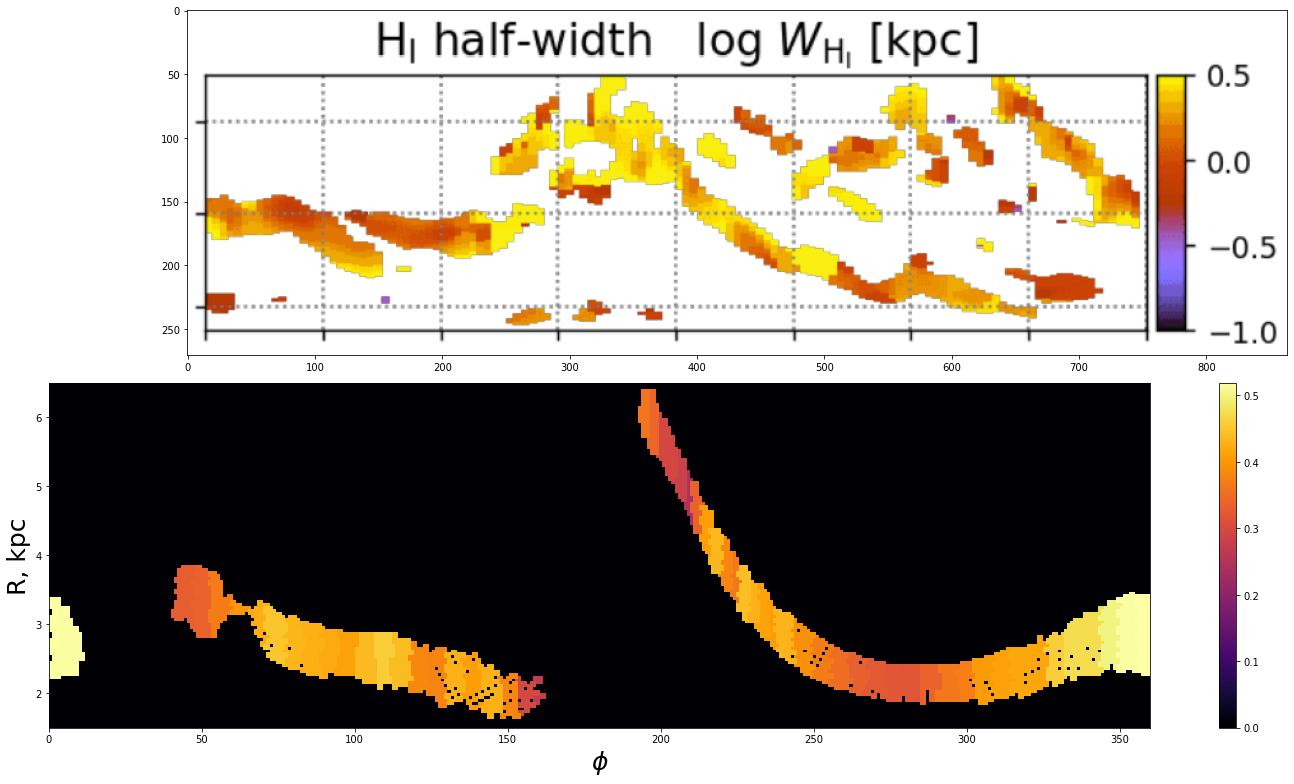

In [37]:
X,Y = np.meshgrid(np.linspace(0,360,360), np.linspace(1.5,6.5,120))
fig, axes = plt.subplots(2, 1,figsize=[20, 11])
axes[0].imshow(Im.open('./images/half-width.png'))

axes[1].set_ylabel(r'R, kpc', fontsize = 25)
axes[1].set_xlabel(r'$\phi$', fontsize = 25)
axes[1]= plt.pcolormesh(X,Y, maps_width,cmap='inferno')
plt.colorbar()
plt.tight_layout()
plt.show()

<ipython-input-43-bdc584dcea90>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axes[1]= plt.pcolormesh(X,Y, maps_width_st,cmap='inferno')


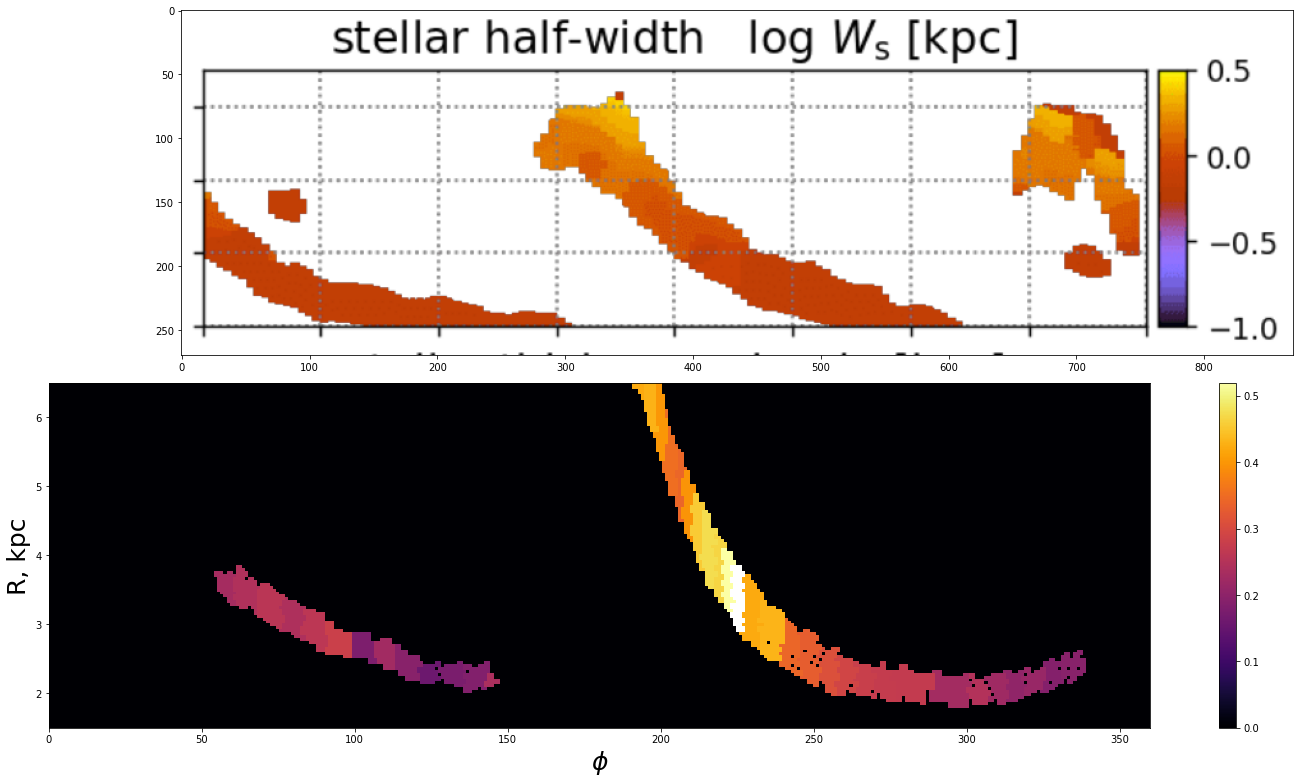

In [43]:
X,Y = np.meshgrid(np.linspace(0,360,360), np.linspace(1.5,6.5,120))
fig, axes = plt.subplots(2, 1,figsize=[20, 11])
axes[0].imshow(Im.open('./images/stellar_width.png'))

axes[1].set_ylabel(r'R, kpc', fontsize = 25)
axes[1].set_xlabel(r'$\phi$', fontsize = 25)
axes[1]= plt.pcolormesh(X,Y, maps_width_st,cmap='inferno')
plt.colorbar()
plt.tight_layout()
plt.show()

<ipython-input-42-71f957cf2fba>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axes[1]=plt.pcolormesh(X,Y,np.log10(maps_HI*10**6),cmap='magma')


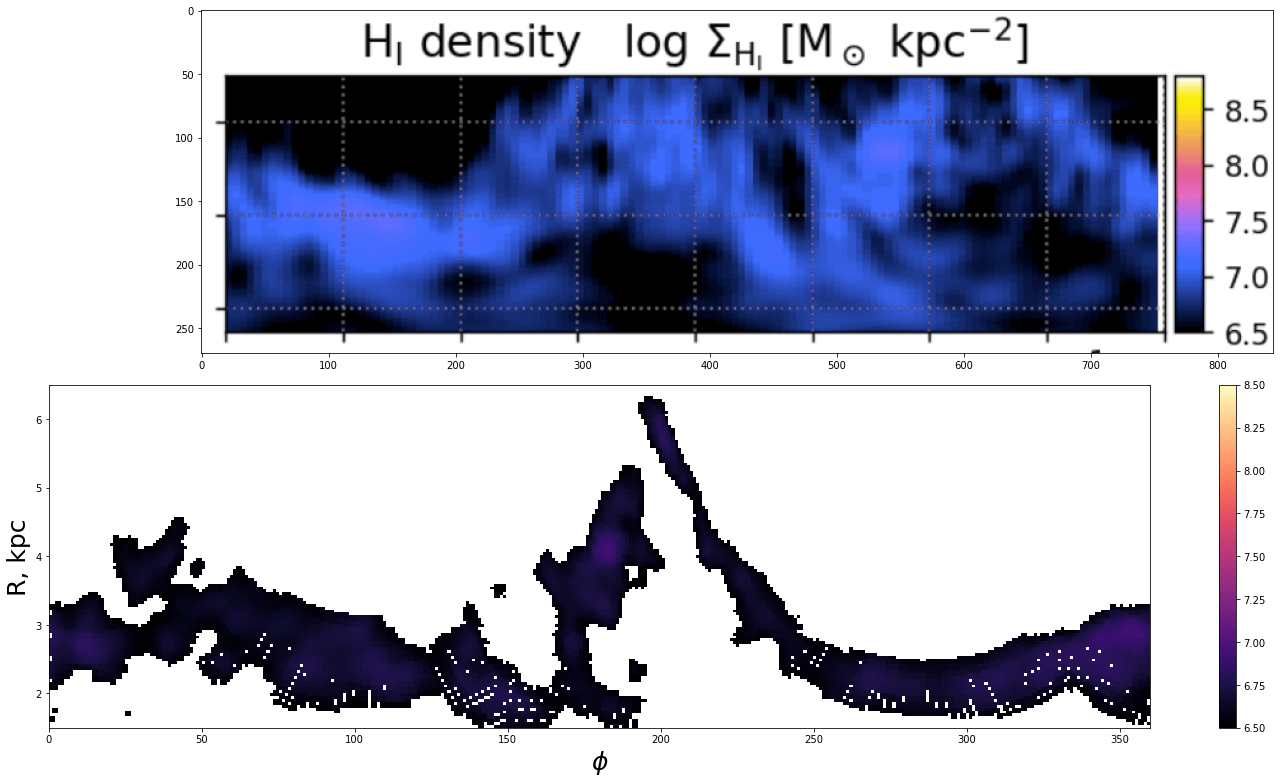

In [42]:
X,Y = np.meshgrid(np.linspace(0,360,360), np.linspace(1.5,6.5,120))
fig, axes = plt.subplots(2, 1,figsize=[20, 11])

axes[0].imshow(Im.open('./images/HI_dens.png'))

axes[1].set_ylabel(r'R, kpc', fontsize = 25)
axes[1].set_xlabel(r'$\phi$', fontsize = 25)
axes[1]=plt.pcolormesh(X,Y,np.log10(maps_HI*10**6),cmap='magma')

axes[1].set_clim(vmin=6.5, vmax=8.5)
plt.colorbar()
plt.tight_layout()
plt.show()

<ipython-input-44-11591ee64177>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axes[1]=plt.pcolormesh(X,Y,np.log10(maps_H2*10**6),cmap='magma')


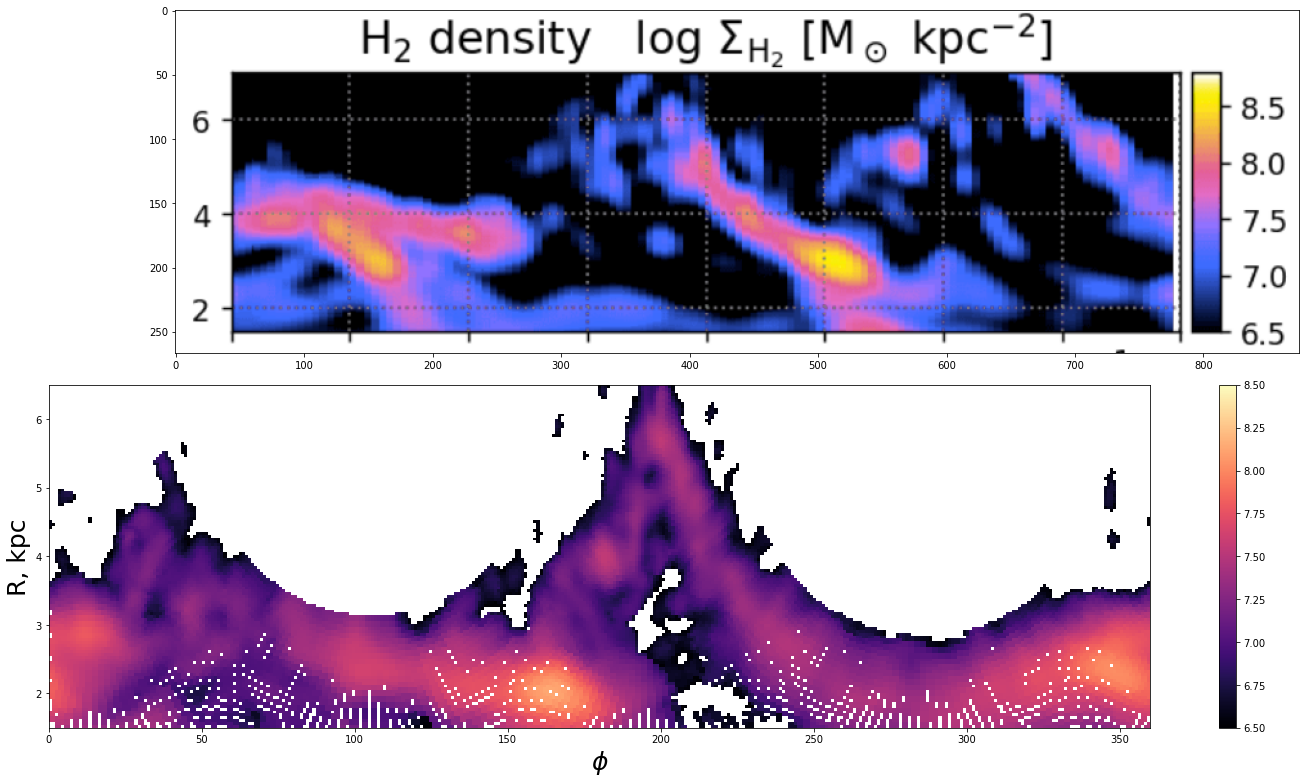

In [44]:
X,Y = np.meshgrid(np.linspace(0,360,360), np.linspace(1.5,6.5,120))
fig, axes = plt.subplots(2, 1,figsize=[20, 11])

axes[0].imshow(Im.open('./images/H2_dens.png'))

axes[1].set_ylabel(r'R, kpc', fontsize = 25)
axes[1].set_xlabel(r'$\phi$', fontsize = 25)
axes[1]=plt.pcolormesh(X,Y,np.log10(maps_H2*10**6),cmap='magma')

axes[1].set_clim(vmin=6.5, vmax=8.5)
plt.colorbar()
plt.tight_layout()
plt.show()

<ipython-input-45-5bb235fc5e2a>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axes[1]=plt.pcolormesh(X,Y,np.log10(maps_star*10**6),cmap='magma')


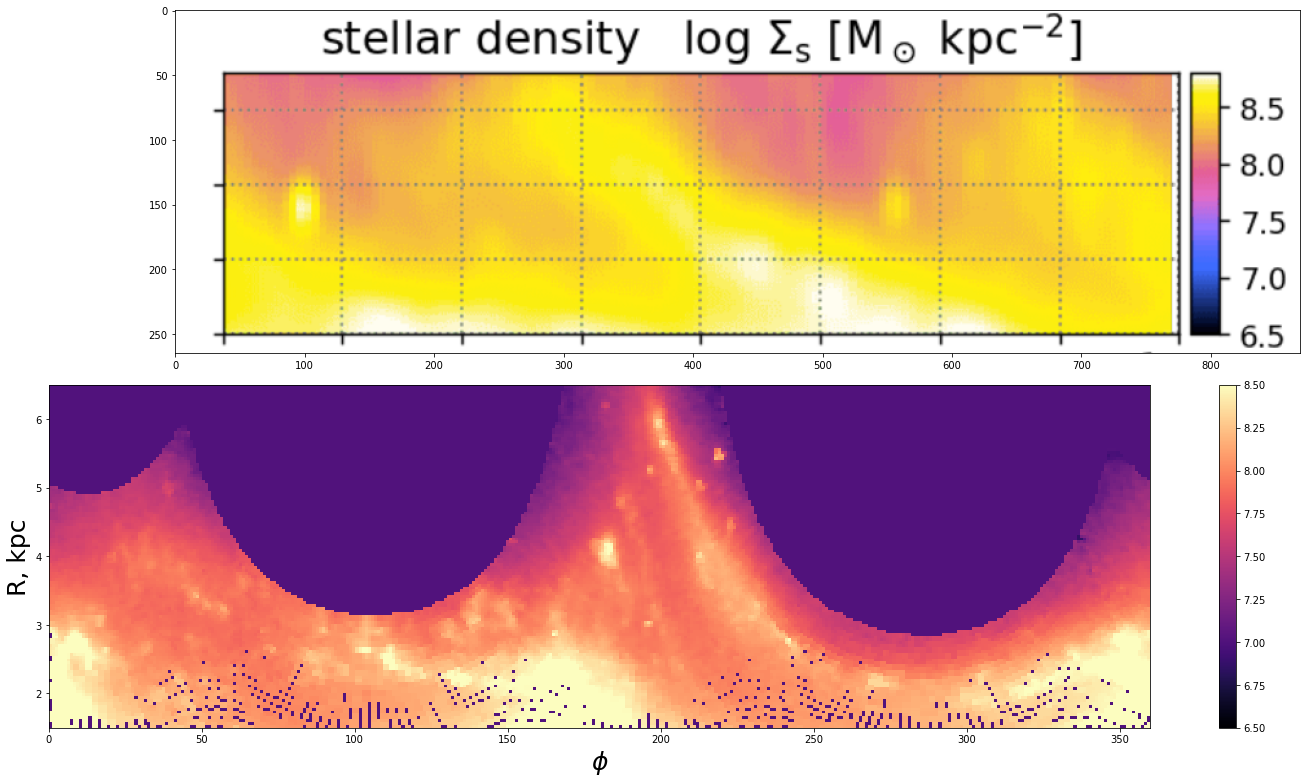

In [45]:
X,Y = np.meshgrid(np.linspace(0,360,360), np.linspace(1.5,6.5,120))
fig, axes = plt.subplots(2, 1,figsize=[20, 11])

axes[0].imshow(Im.open('./images/stellar_dens.png'))

axes[1].set_ylabel(r'R, kpc', fontsize = 25)
axes[1].set_xlabel(r'$\phi$', fontsize = 25)
axes[1]=plt.pcolormesh(X,Y,np.log10(maps_star*10**6),cmap='magma')

axes[1].set_clim(vmin=6.5, vmax=8.5)
plt.colorbar()
plt.tight_layout()
plt.show()

In [120]:
from scipy import stats
try:
    from astropy.convolution import Gaussian2DKernel, convolve
    astro_smooth = True
except ImportError as IE:
    astro_smooth = False

/home/lera/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


Text(0, 0.5, '$\\log{S}$ for HI component')

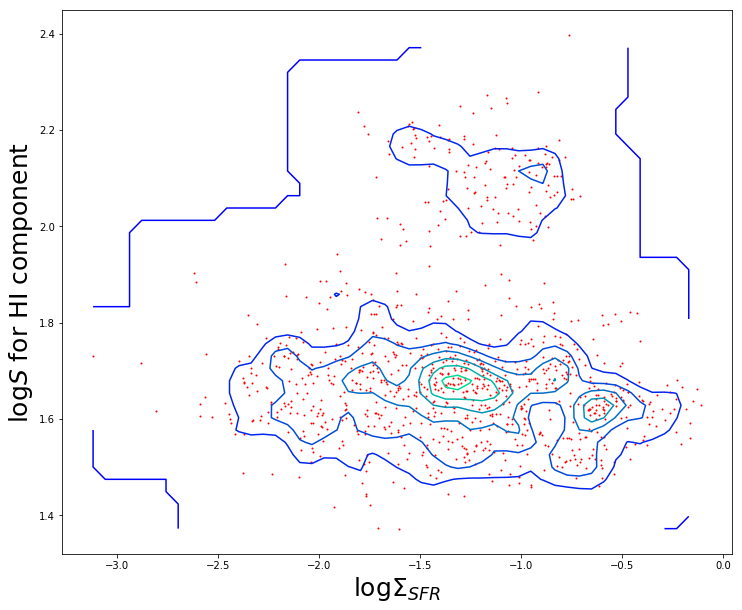

In [121]:
fig = plt.figure(figsize=[12,10])
indxs = (Sigma_SFR != nan) & (width_gas>0) & (Sigma_SFR != 0) & (np.log10(Sigma_SFR) < 0)

x,y = np.ravel(np.log10(Sigma_SFR)[indxs]), np.log10(np.ravel(inst_param_HI[indxs]))

x=np.nan_to_num(x)
y=np.nan_to_num(y)


H, xedges, yedges = np.histogram2d(x,y, bins=(50,40))
xmesh, ymesh = np.meshgrid(xedges[:-1], yedges[:-1])
# Smooth the contours (if astropy is installed)
if astro_smooth:
    kernel = Gaussian2DKernel(stddev=1.)
    H=convolve(H,kernel)
    
clevels = plt.contour(xmesh,ymesh,H.T,lw=.6,cmap='winter')#,zorder=90)
plt.scatter(x,y, 1., color='r')

plt.xlabel(r'$\log{\Sigma_{SFR}}$',fontsize=25)
plt.ylabel(r'$\log{S}$ for HI component',fontsize=25)

/home/lera/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


Text(0, 0.5, '$\\log{S}$ for H2 component')

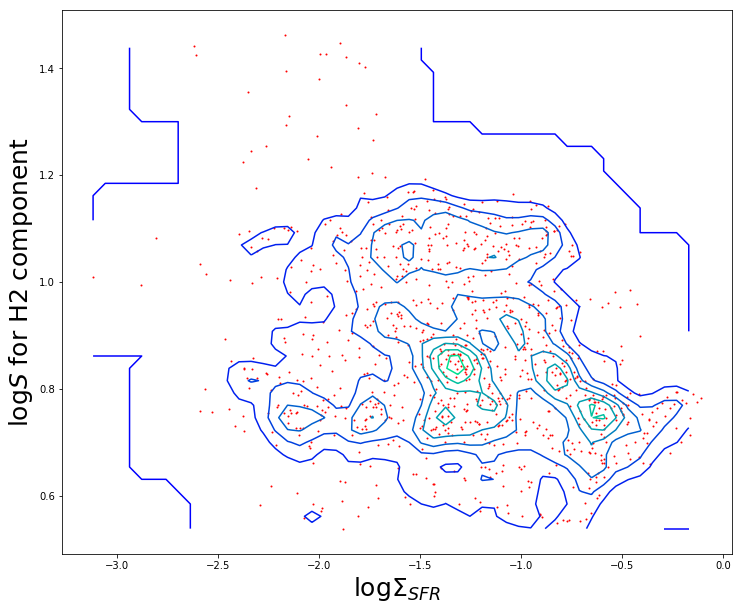

In [122]:
fig = plt.figure(figsize=[12,10])
indxs = (Sigma_SFR != nan) & (width_gas>0) & (Sigma_SFR != 0.) & (np.log10(Sigma_SFR) < 0)

x,y = np.ravel(np.log10(Sigma_SFR)[indxs]), np.log10(np.ravel(inst_param_H2[indxs]))

x=np.nan_to_num(x)
y=np.nan_to_num(y)


H, xedges, yedges = np.histogram2d(x,y, bins=(50,40))
xmesh, ymesh = np.meshgrid(xedges[:-1], yedges[:-1])
# Smooth the contours (if astropy is installed)
if astro_smooth:
    kernel = Gaussian2DKernel(stddev=1.)
    H=convolve(H,kernel)
    
clevels = plt.contour(xmesh,ymesh,H.T,lw=.6,cmap='winter')#,zorder=90)
plt.scatter(x,y, 1., color='r')

plt.xlabel(r'$\log{\Sigma_{SFR}}$',fontsize=25)
plt.ylabel(r'$\log{S}$ for H2 component',fontsize=25)

/home/lera/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/home/lera/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


Text(0, 0.5, '$\\log{S}$ for stellar component')

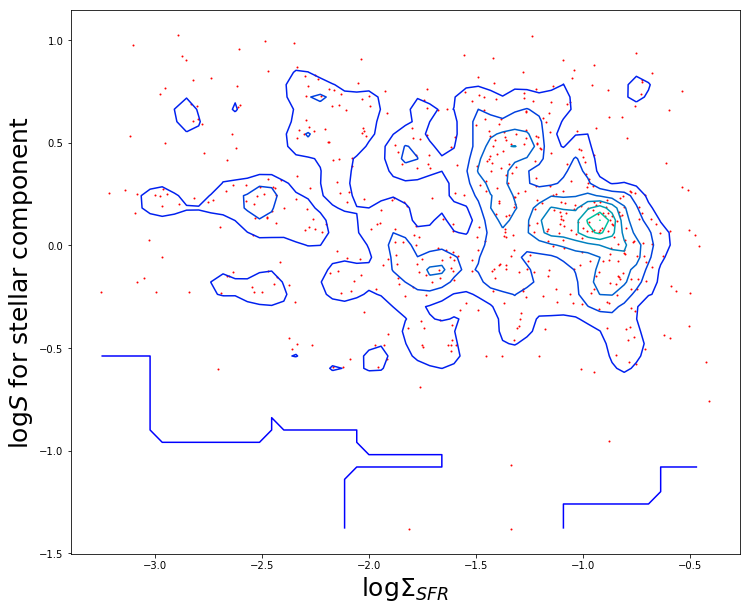

In [123]:
fig = plt.figure(figsize=[12,10])
indxs = (Sigma_SFR != nan) & (width_star>0) & (Sigma_SFR != 0.) & (np.log10(Sigma_SFR) < 0)# & (dist_kpc<4)

x,y = np.ravel(np.log10(Sigma_SFR)[indxs]), np.log10(np.ravel(inst_param_star[indxs]))

x=np.nan_to_num(x)
y=np.nan_to_num(y)


H, xedges, yedges = np.histogram2d(x,y, bins=(50,40))
xmesh, ymesh = np.meshgrid(xedges[:-1], yedges[:-1])
# Smooth the contours (if astropy is installed)
if astro_smooth:
    kernel = Gaussian2DKernel(stddev=1.)
    H=convolve(H,kernel)
    
clevels = plt.contour(xmesh,ymesh,H.T,lw=.6,cmap='winter')#,zorder=90)
plt.scatter(x,y, 1., color='r')

plt.xlabel(r'$\log{\Sigma_{SFR}}$',fontsize=25)
plt.ylabel(r'$\log{S}$ for stellar component',fontsize=25)

/home/lera/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/home/lera/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


Text(0, 0.5, '$\\log{S}$ for three components')

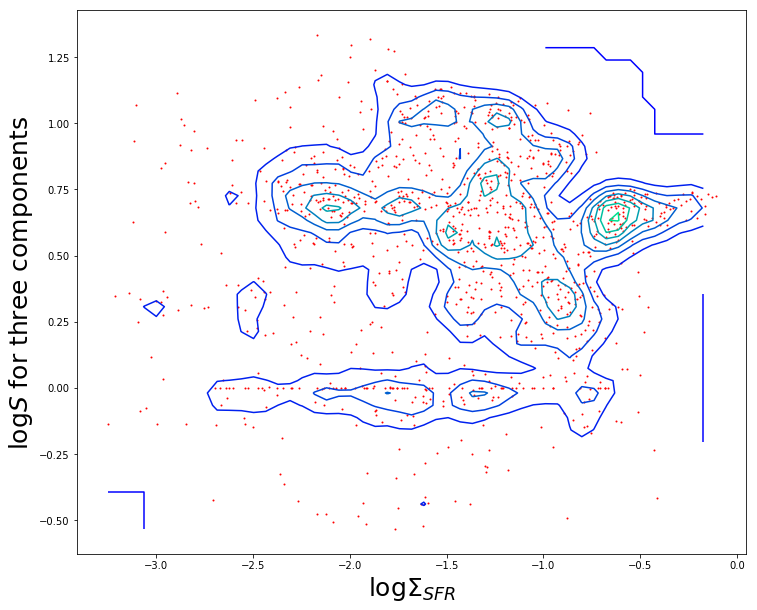

In [124]:
fig = plt.figure(figsize=[12,10])
indxs = (Sigma_SFR != np.nan) & ((width_gas>0) | (width_star>0)) & (Sigma_SFR != 0.) & (np.log10(Sigma_SFR) < 0)# & (dist_kpc<4)

x,y = np.ravel(np.log10(Sigma_SFR)[indxs]), np.log10(np.ravel(inst_param_full[indxs]))

x=np.nan_to_num(x)
y=np.nan_to_num(y)


H, xedges, yedges = np.histogram2d(x,y, bins=(50,40))
xmesh, ymesh = np.meshgrid(xedges[:-1], yedges[:-1])
# Smooth the contours (if astropy is installed)
if astro_smooth:
    kernel = Gaussian2DKernel(stddev=1.)
    H=convolve(H,kernel)
    
clevels = plt.contour(xmesh,ymesh,H.T,lw=.6,cmap='winter')#,zorder=90)
plt.scatter(x,y, 1., color='r')

plt.xlabel(r'$\log{\Sigma_{SFR}}$',fontsize=25)
plt.ylabel(r'$\log{S}$ for three components',fontsize=25)

### Поварьируем параметры критерия

In [46]:
x = np.linspace(1,50,100)
G = 4.32
mean_error_min = []
std_error_min = []
array_errors = []
step = 0
for percent in np.arange(-35.,40.,5.):
    inst_param_H2_ = np.zeros(dist_kpc.shape)
    errors_min = np.zeros(dist_kpc.shape)
    errors = []
    
    for i, row in enumerate(dist_kpc):
        for j, col in enumerate(dist_kpc[0]):
        
                if (width_gas[i][j] != 0):
                    sigma_ = sigma_HI[i][j]/1000.
                    Omega = (1. + percent/100.) * 50.
                    W_ = width_gas[i][j]
                    Y_ = 1.44 * W_ * Sigma_H2_peak[i][j]
                    S_ = (sigma_**2 * x**2 + 4 * Omega**2) / (np.pi * G * f(x*W_) * Y_ * x**2)
                    inst_param_H2_[i][j] = np.min(np.abs(S_))
                   
                
    mask = (width_gas != 0)                    
    errors_min = np.divide(inst_param_H2_[mask]*100.,inst_param_H2[mask]) - 100
    errors.append(np.ravel(np.divide(inst_param_H2_[mask]*100.,inst_param_H2[mask]) - 100))
            
    array_errors.append(errors)
    mean_error_min.append(errors_min.mean())
    std_error_min.append(errors_min.std())

    
np.save('./data/mean_error_Omega.npy',mean_error_min)
np.save('./data/array_errors_Omega.npy',array_errors)
np.save('./data/std_error_Omega.npy',std_error_min)

In [47]:
G = 4.32
mean_error_min = []
std_error_min = []
array_errors = []

for percent in np.arange(-35.,40.,5.):
    inst_param_H2_ = np.zeros(dist_kpc.shape)
    errors_min = np.zeros(dist_kpc.shape)
    errors_max = np.zeros(dist_kpc.shape)
    errors = []
    inst_param_H2_[:,:] = np.nan

    for i, row in enumerate(dist_kpc):
        for j, col in enumerate(dist_kpc[0]):
        
                if (width_gas[i][j] != 0):
                    sigma_ = (1. + percent/100.) * sigma_HI[i][j]/1000.
                    Omega =  50.
                    W_ = width_gas[i][j]
                    Y_ = 1.44 * W_ * Sigma_H2_peak[i][j]
                    S_ = (sigma_**2 * x**2 + 4 * Omega**2) / (np.pi * G * f(x*W_) * Y_ * x**2)
                    inst_param_H2_[i][j] = np.min(np.abs(S_))
                   
                
    mask = (width_gas != 0)                    
    errors_min = np.divide(inst_param_H2_[mask]*100.,inst_param_H2[mask]) - 100
    errors.append(np.ravel(np.divide(inst_param_H2_[mask]*100.,inst_param_H2[mask]) - 100))
    
    array_errors.append(errors)
    mean_error_min.append(errors_min.mean())
    std_error_min.append(errors_min.std())

    
np.save('./data/mean_error_sigma.npy',mean_error_min)
np.save('./data/array_errors_sigma.npy',array_errors)
np.save('./data/std_error_sigma.npy',std_error_min)

In [48]:
G = 4.32
mean_error_min = []
std_error_min = []
array_errors = []

for percent in np.arange(-35.,40.,5.):
    inst_param_H2_ = np.zeros(dist_kpc.shape)
    errors_min = np.zeros(dist_kpc.shape)
    errors_max = np.zeros(dist_kpc.shape)
    errors = []
    
    inst_param_H2_[:,:] = np.nan

    for i, row in enumerate(dist_kpc):
        for j, col in enumerate(dist_kpc[0]):
        
                 if (width_gas[i][j] != 0):
                    sigma_ = sigma_HI[i][j]/1000.
                    Omega =  50.
                    W_ = (1. + percent/100.) * width_gas[i][j]
                    Y_ = 1.44 * W_ * Sigma_H2_peak[i][j]
                    S_ = (sigma_**2 * x**2 + 4 * Omega**2) / (np.pi * G * f(x*W_) * Y_ * x**2)
                    inst_param_H2_[i][j] = np.min(np.abs(S_))
                   
                
    mask = (width_gas != 0)                    
    errors_min = np.divide(inst_param_H2_[mask]*100.,inst_param_H2[mask]) - 100
    errors.append(np.ravel(np.divide(inst_param_H2_[mask]*100.,inst_param_H2[mask]) - 100))
            
    array_errors.append(errors)
    mean_error_min.append(errors_min.mean())
    std_error_min.append(errors_min.std())

    
np.save('./data/mean_error_width.npy',mean_error_min)
np.save('./data/array_errors_width.npy',array_errors)
np.save('./data/std_error_width.npy',std_error_min)

In [49]:
G = 4.32
mean_error_min = []
std_error_min = []
array_errors = []

for percent in np.arange(-35.,40.,5.):
    inst_param_H2_ = np.zeros(dist_kpc.shape)
    errors_min = np.zeros(dist_kpc.shape)
    errors_max = np.zeros(dist_kpc.shape)
    errors = []
    inst_param_H2_[:,:] = np.nan

    for i, row in enumerate(dist_kpc):
        for j, col in enumerate(dist_kpc[0]):
        
                if (width_gas[i][j] != 0):
                    sigma_ = sigma_HI[i][j]/1000.
                    Omega =  50.
                    W_ = width_gas[i][j]
                    Y_ = (1. + percent/100.) * 1.44 * W_ * Sigma_H2_peak[i][j]
                    S_ = (sigma_**2 * x**2 + 4 * Omega**2) / (np.pi * G * f(x*W_) * Y_ * x**2)
                    inst_param_H2_[i][j] = np.min(np.abs(S_))
                   
                
    mask = (width_gas != 0)                    
    errors_min = np.divide(inst_param_H2_[mask]*100.,inst_param_H2[mask]) - 100
    errors.append(np.ravel(np.divide(inst_param_H2_[mask]*100.,inst_param_H2[mask]) - 100))
            
    array_errors.append(errors)
    mean_error_min.append(errors_min.mean())
    std_error_min.append(errors_min.std())

    
np.save('./data/mean_error_Sigma.npy',mean_error_min)
np.save('./data/array_errors_Sigma.npy',array_errors)
np.save('./data/std_error_Sigma.npy',std_error_min)

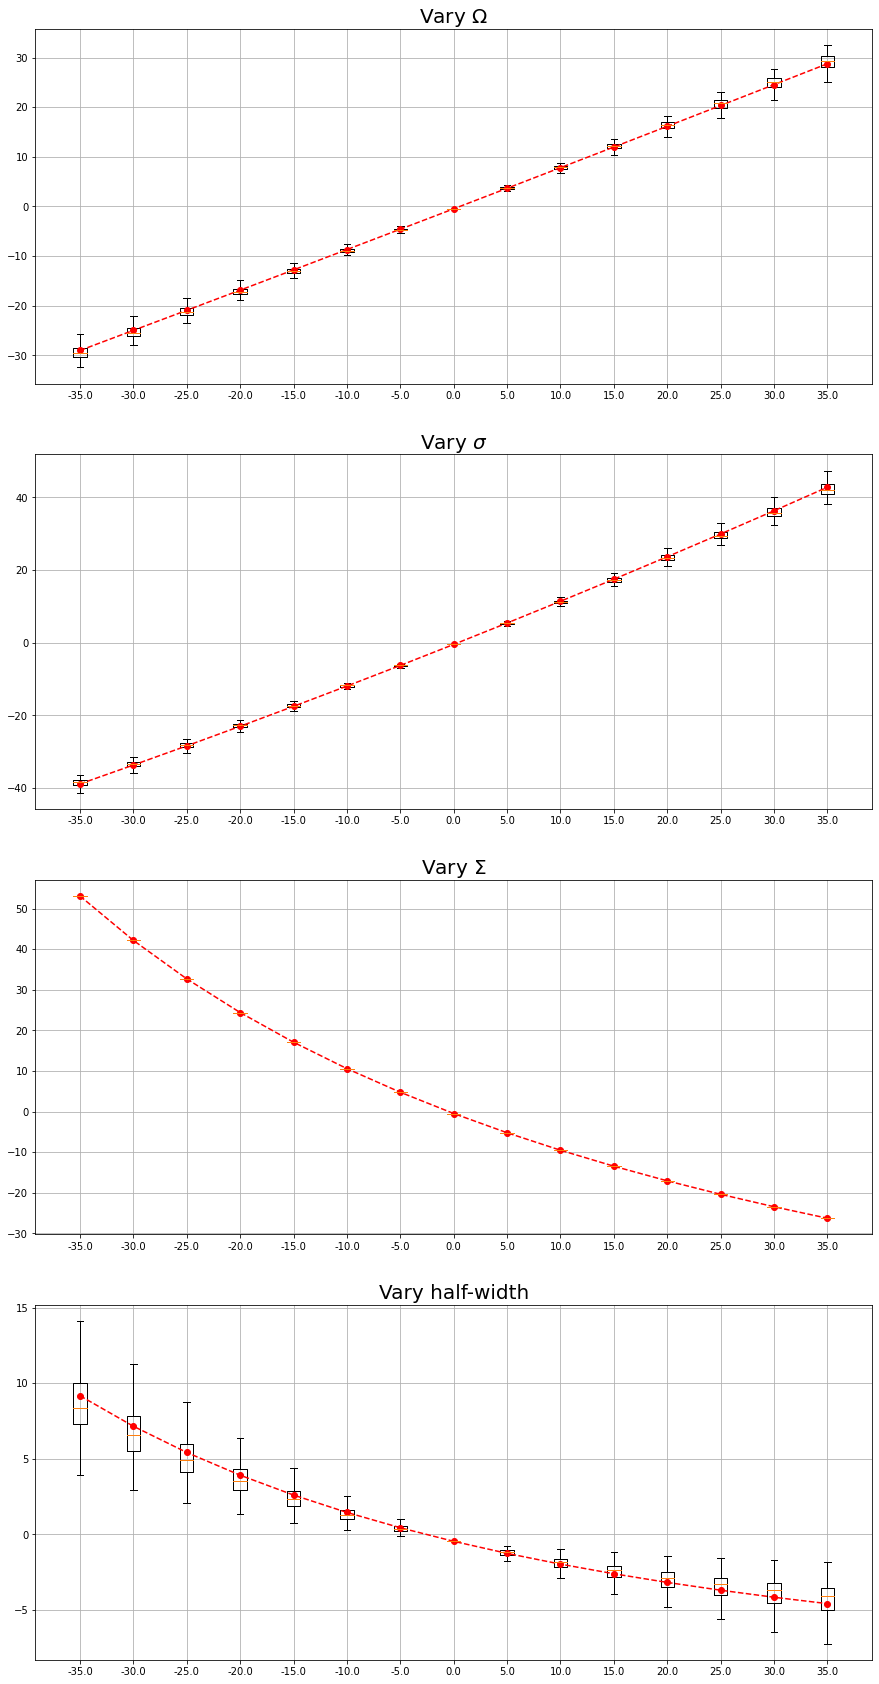

In [50]:

plt.figure(figsize=[15,30])
plt.subplot(4,1,1)

array_errors = np.load('./data/array_errors_Omega.npy')
array_errors = np.array(np.transpose(array_errors)).reshape(1348,15)
mean_error_min  =  np.load('./data/mean_error_Omega.npy')
plt.boxplot(array_errors,positions=np.array(np.arange(-35.,40.,5.)),showfliers=False, patch_artist =False, widths = 1.25) 
plt.plot(np.array(np.arange(-35.,40.,5.)),mean_error_min, 'o--', color='red')
plt.title(r'Vary $\Omega$', fontsize=20)
plt.grid()

plt.subplot(4,1,2)

array_errors = np.load('./data/array_errors_sigma.npy')
array_errors = np.array(np.transpose(array_errors)).reshape(1348,15)
mean_error_min  =  np.load('./data/mean_error_sigma.npy')
plt.boxplot(array_errors,positions=np.array(np.arange(-35.,40.,5.)),showfliers=False, patch_artist =False, widths = 1.25) 
plt.plot(np.array(np.arange(-35.,40.,5.)),mean_error_min, 'o--', color='red')
plt.title(r'Vary $\sigma$', fontsize=20)
plt.grid()

plt.subplot(4,1,3)

array_errors = np.load('./data/array_errors_Sigma.npy')
array_errors = np.array(np.transpose(array_errors)).reshape(1348,15)
mean_error_min  =  np.load('./data/mean_error_Sigma.npy')
plt.boxplot(array_errors,positions=np.array(np.arange(-35.,40.,5.)),showfliers=False, patch_artist =False, widths = 1.25) 
plt.plot(np.array(np.arange(-35.,40.,5.)),mean_error_min, 'o--', color='red')
plt.title(r'Vary $\Sigma$', fontsize=20)
plt.grid()

plt.subplot(4,1,4)

array_errors = np.load('./data/array_errors_width.npy')
array_errors = np.array(np.transpose(array_errors)).reshape(1348,15)
mean_error_min  =  np.load('./data/mean_error_width.npy')
plt.boxplot(array_errors,positions=np.array(np.arange(-35.,40.,5.)),showfliers=False, patch_artist =False, widths = 1.25) 
plt.plot(np.array(np.arange(-35.,40.,5.)),mean_error_min, 'o--', color='red')
plt.title(r'Vary half-width', fontsize=20)
plt.grid()

In [158]:
mean_error_Sigma = np.load('./data/mean_error_Sigma.npy')
mean_error_sigma = np.load('./data/mean_error_sigma.npy')
mean_error_Omega = np.load('./data/mean_error_Omega.npy')
mean_error_width = np.load('./data/mean_error_width.npy')


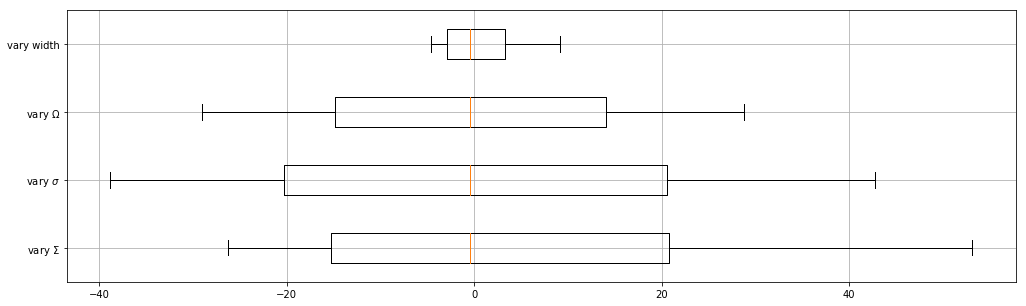

In [159]:
array = [mean_error_Sigma,mean_error_sigma,mean_error_Omega,mean_error_width]
plt.figure(figsize=[17,5])
plt.boxplot(array,showfliers=False, vert=False, labels=[r'vary $\Sigma$',r'vary $\sigma$',r'vary $\Omega$',
                                            r'vary width'] )

plt.grid()

Для начала обрежем карту с маской до нужных нам размеров.

In [16]:
image_file_ = get_pkg_data_filename('spirals/arms_mask_projected_corrected_HI.fits')
image_data_ = fits.getdata(image_file_, ext=0)
print(image_data_.shape)

(1200, 1200)


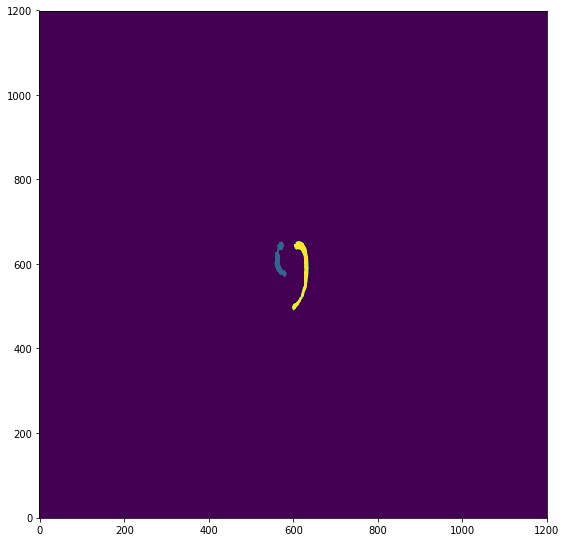

In [17]:
fig = plt.figure(figsize=[20,10])
ax = plt.subplot(121)

ax.imshow(image_data_.data,origin='lower')

In [18]:
# обрезаем данные
# по сути все как в get_data только без функций
image_file = get_pkg_data_filename('spirals/arms_mask_projected_corrected_HI.fits')
image_file = fits.getdata(image_file)
image_data_ = np.squeeze(image_file)
image_data = np.zeros((1024,1024))
image_data = image_data_[76:,76:]

data = fits.getdata('./data/NGC_3627_NA_MOM0_THINGS.FITS')
data = np.squeeze(data)
data_WCS = WCS('./data/NGC_3627_NA_MOM0_THINGS.FITS', naxis = 2)
cposition= SkyCoord('170.06205 12.9917', frame='icrs', unit='deg', equinox='J2000.0')

size = [380,160] 
size_ = u.Quantity(size, u.arcsec)

data = Cutout2D(data, cposition, size_, wcs=data_WCS, mode='partial', fill_value=0.)    
image_data = Cutout2D(image_data, cposition, size_, wcs=data_WCS, mode='partial', fill_value=0.)
#image_data = np.squeeze(image_data)

# теперь делаем их нужной размерности
shape = [190,80]
first_data = fits.getdata('./data/NGC3627_map_ha_corr.fits')
first_data = np.squeeze(first_data)
first_WCS = WCS('./data/NGC3627_map_ha_corr.fits', naxis = 2)
first_data = Cutout2D(first_data, cposition, size_, wcs=first_WCS, mode='partial', fill_value=0.)

print(first_data.shape)
X, Y = np.meshgrid(np.arange(0, shape[1], 1), np.arange(0, shape[0], 1))
sgrid = pixel_to_skycoord(X.ravel(), Y.ravel(), first_data.wcs).reshape((shape[0], shape[1]))
    
grid_pixs = []
new_data = []
for scoord in sgrid.ravel():
    spix = skycoord_to_pixel(scoord, data.wcs)
    grid_pixs.append(spix)
    new_data.append(image_data.data[int(spix[1]),int(spix[0])])
    
new_data = np.array(new_data).reshape(190,80)   

#mask_gas = new_data[0:-34,0:-4]

(190, 80)


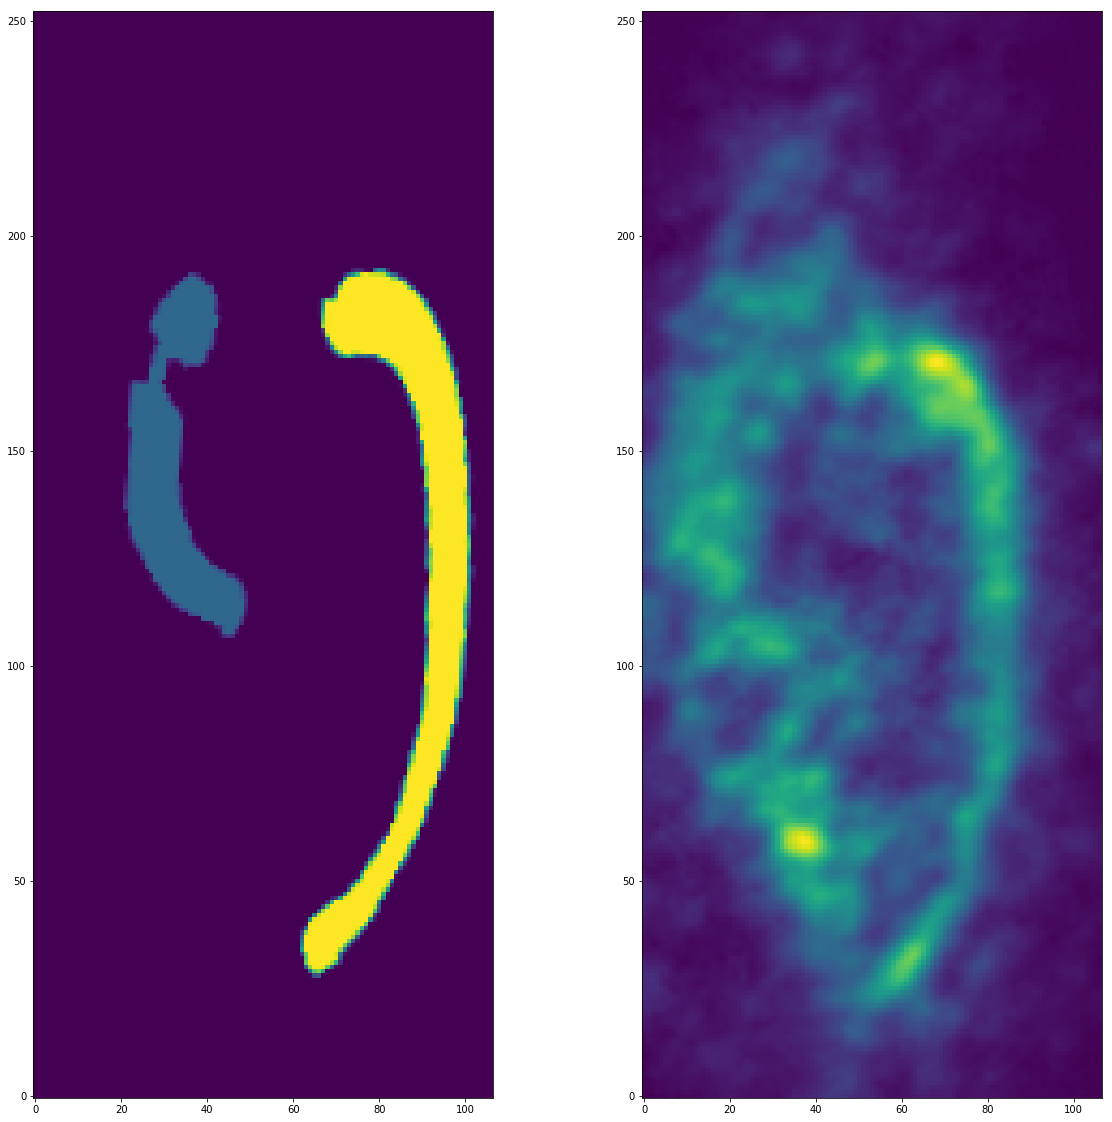

In [19]:
fig = plt.figure(figsize=[20,20])
ax = plt.subplot(121)
ax.imshow(image_data.data,origin='lower')
ax_ = plt.subplot(122)
ax_.imshow(data.data,origin='lower')

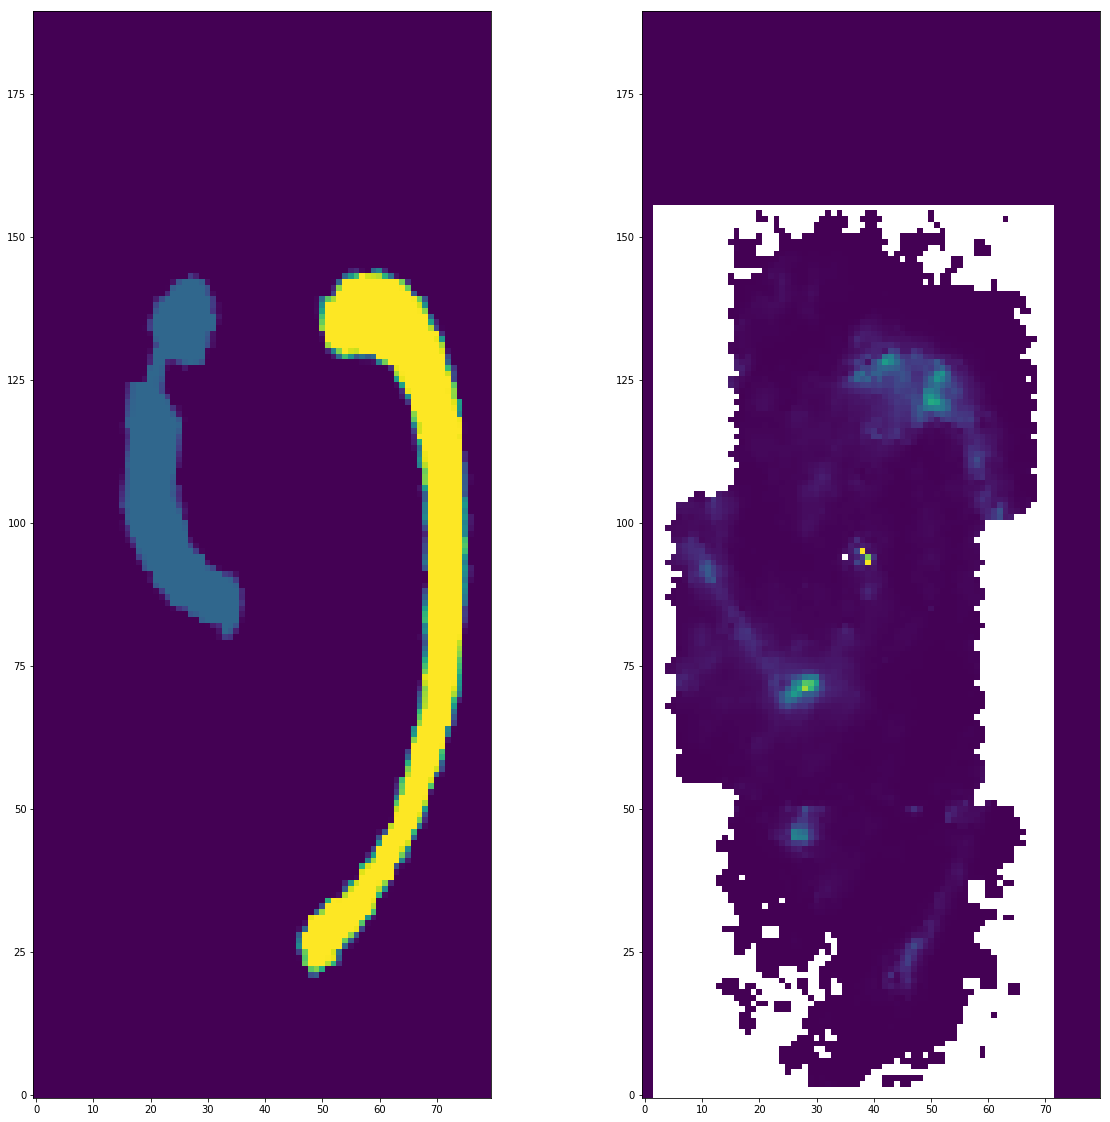

In [20]:
fig = plt.figure(figsize=[20,20])
ax = plt.subplot(121)
ax.imshow(new_data,origin='lower')
ax_ = plt.subplot(122)
ax_.imshow(first_data.data,origin='lower')

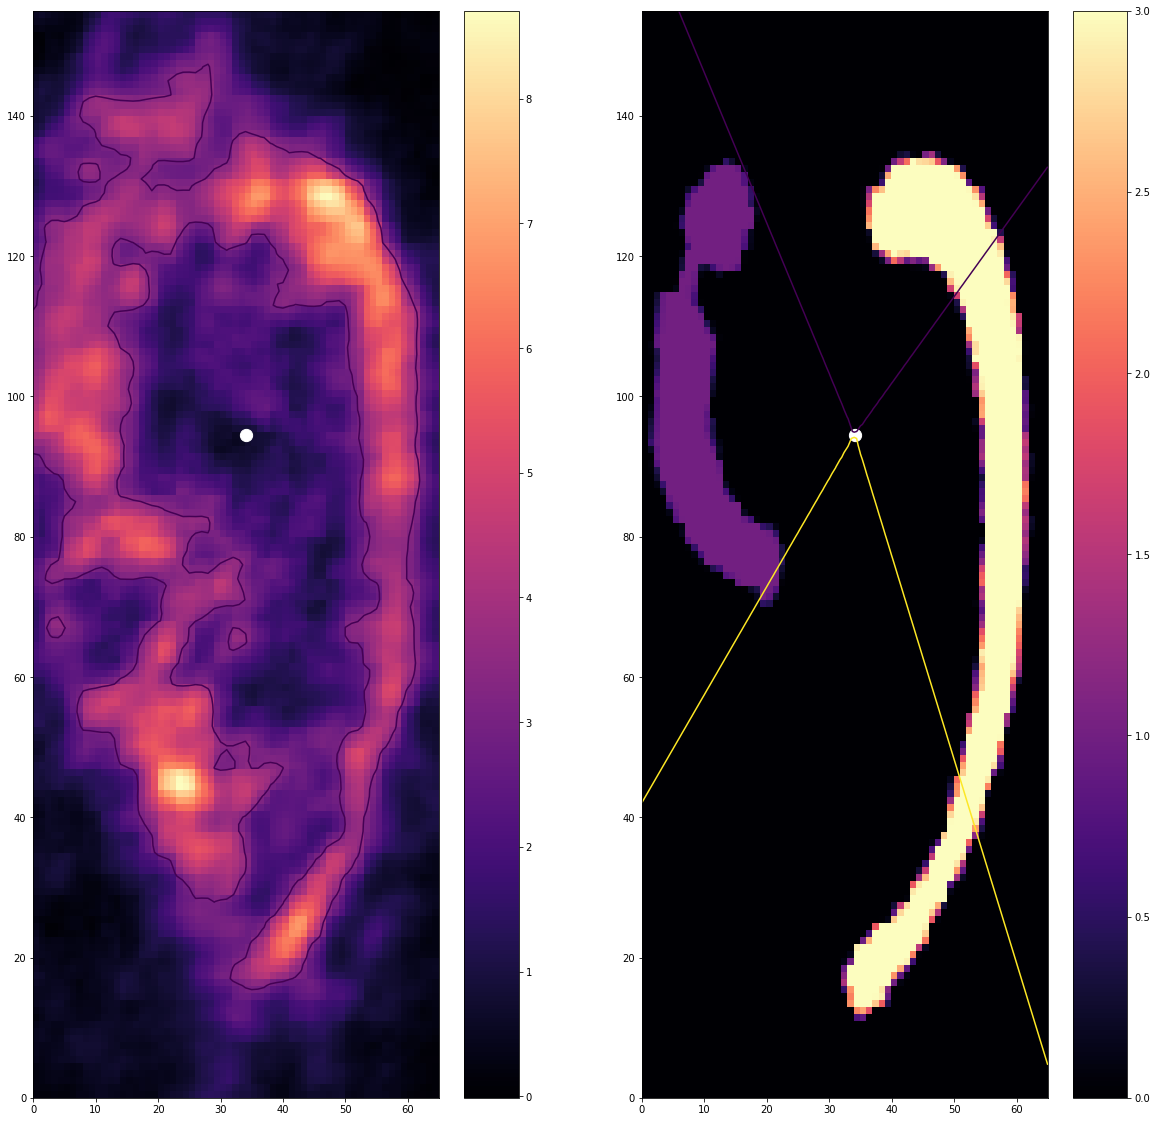

In [35]:
X,Y = np.meshgrid(np.arange(0.,66,1), np.arange(0.,156,1))
X1,Y1 = np.meshgrid(np.arange(0.,80,1), np.arange(0.,190,1))

fig = plt.figure(figsize=[20,20])
plt.subplot(1,2,1)
CS = plt.contour(X, Y, Sigma_HI, levels=[3.2,], aspect='black')
quadmesh = plt.pcolormesh(X, Y, Sigma_HI, cmap='magma')
quadmesh.cmap.set_under('white')
plt.colorbar()
plt.scatter(34.06509169 ,94.54027961,[150.], color='white' )

plt.subplot(1,2,2)
new_data_ = new_data[10:-24,14:]
CS = plt.contour(X, Y, phi, levels=[32., 154.], color='white')
quadmesh = plt.pcolormesh(X, Y, new_data_, cmap='magma')
#quadmesh.set_clim(vmin=0., vmax=7000.)
quadmesh.cmap.set_under('white')
plt.colorbar()
plt.scatter(34.06509169 ,94.54027961,[150.], color='white' )


In [26]:
mask_gas = new_data[10:-24,14:]
np.save('./data/mask_gas.npy', mask_gas)

Попробуем обрезать маску для звездного диска

In [29]:
image_file = get_pkg_data_filename('spirals/tst.fits')
image_data = fits.getdata(image_file, ext=0)
image_file_ = get_pkg_data_filename('spirals/arms.fits')
image_data_ = fits.getdata(image_file_, ext=0)

data_WCS = WCS('spirals/tst.fits', naxis = 2)
print(data_WCS)

WCS Keywords

Number of WCS axes: 2
CTYPE : ''  ''  
CRVAL : 0.0  0.0  
CRPIX : 0.0  0.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 1.0  1.0  
NAXIS : 267  533


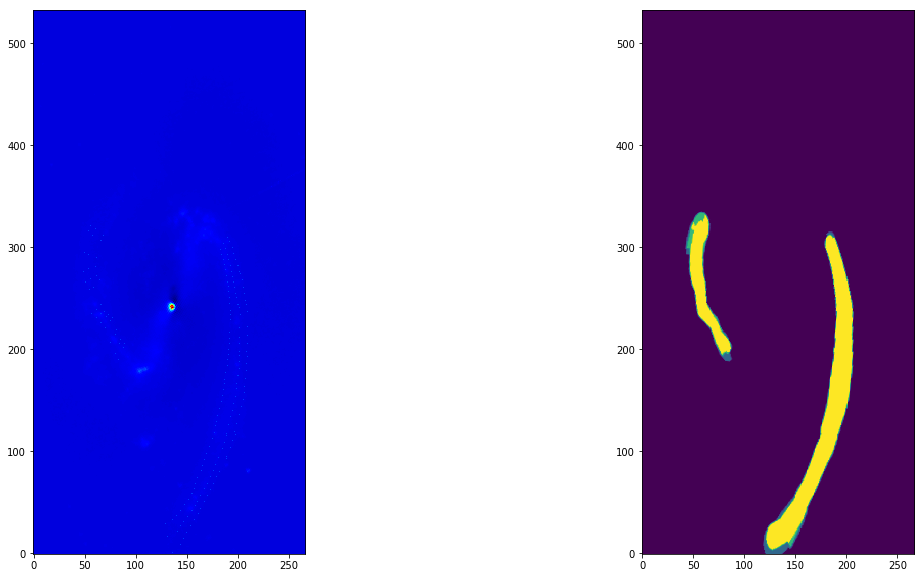

In [30]:
fig = plt.figure(figsize=[20,10])
ax = plt.subplot(121)

pic = ax.imshow(image_data,cmap='jet',origin='lower')

ax_ = plt.subplot(122)

ax_.imshow(image_data_,origin='lower')

In [31]:
data = fits.getdata('./data/NGC3627.phot.1_nonan.fits')
data = np.squeeze(data)
data_WCS = WCS('./data/NGC3627.phot.1_nonan.fits', naxis = 2)
cposition = SkyCoord('{} {}'.format(data_WCS.wcs.crval[0], data_WCS.wcs.crval[1]), frame='fk5', unit='deg', equinox='J2000.0')

size = [400,200] 
size_ = u.Quantity(size, u.arcsec)

data = Cutout2D(data, cposition, size, wcs=data_WCS, mode='partial', fill_value=0.)

first_data = fits.getdata('./data/NGC3627_map_ha_corr.fits')
first_data = np.squeeze(first_data)
first_WCS = WCS('./data/NGC3627_map_ha_corr.fits', naxis = 2)
first_data = Cutout2D(first_data, cposition, size_, wcs=first_WCS, mode='partial', fill_value=0.)

X, Y = np.meshgrid(np.arange(0, 100, 1), np.arange(0, 200, 1))
sgrid = pixel_to_skycoord(X.ravel(), Y.ravel(), first_data.wcs).reshape((200, 100))

image_data = np.squeeze(image_data)

grid_pixs = []
new_data = []
for scoord in sgrid.ravel():
    spix = skycoord_to_pixel(scoord, data.wcs)
    grid_pixs.append(spix)
    new_data.append(image_data[int(spix[1])][int(spix[0])])
    
new_data = np.array(new_data).reshape(200,100) 


INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


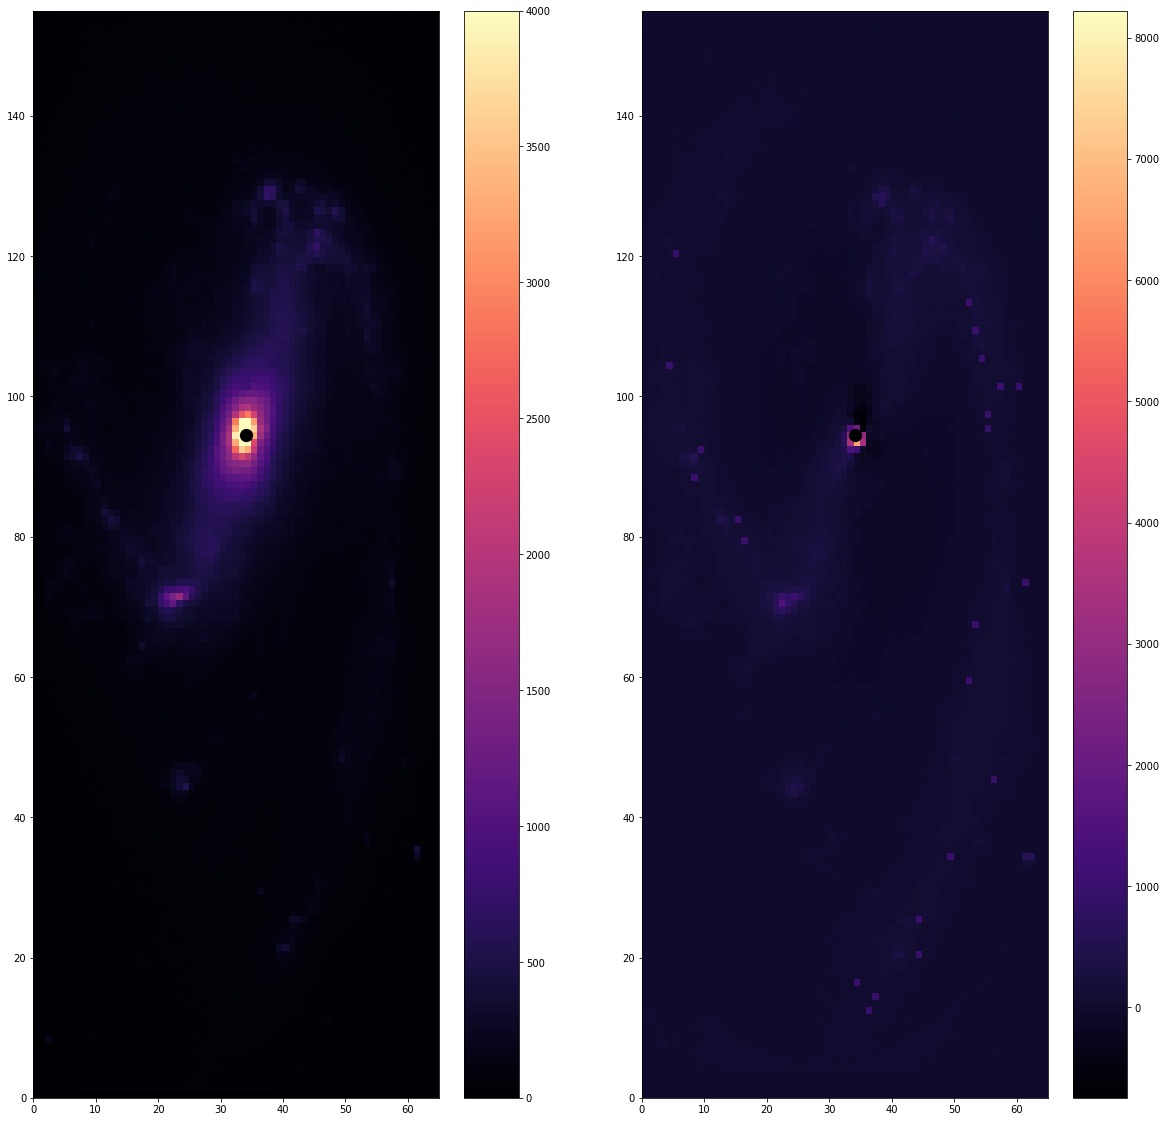

In [32]:
X,Y = np.meshgrid(np.arange(0.,66,1), np.arange(0.,156,1))
X1,Y1 = np.meshgrid(np.arange(0.,100,1), np.arange(0.,200,1))

fig = plt.figure(figsize=[20,20])
plt.subplot(1,2,1)
quadmesh = plt.pcolormesh(X, Y, Sigma_s, cmap='magma')
quadmesh.set_clim(vmin=0., vmax=4000.)
quadmesh.cmap.set_under('white')
plt.colorbar()
plt.scatter(34.06509169 ,94.54027961,[150.], color='black' )

plt.subplot(1,2,2)
new_data_ = new_data[22:-22,29:-5]
quadmesh = plt.pcolormesh(X, Y, new_data_, cmap='magma')
#quadmesh.set_clim(vmin=0., vmax=7000.)
quadmesh.cmap.set_under('white')
plt.colorbar()
plt.scatter(34.06509169 ,94.54027961,[150.], color='black' )


теперь проделаем то же самое с маской

In [33]:
data = fits.getdata('./data/NGC3627.phot.1_nonan.fits')
data = np.squeeze(data)
data_WCS = WCS('./data/NGC3627.phot.1_nonan.fits', naxis = 2)
cposition = SkyCoord('{} {}'.format(data_WCS.wcs.crval[0], data_WCS.wcs.crval[1]), frame='fk5', unit='deg', equinox='J2000.0')

size = [400,200] 
size_ = u.Quantity(size, u.arcsec)

data = Cutout2D(data, cposition, size, wcs=data_WCS, mode='partial', fill_value=0.)

first_data = fits.getdata('./data/NGC3627_map_ha_corr.fits')
first_data = np.squeeze(first_data)
first_WCS = WCS('./data/NGC3627_map_ha_corr.fits', naxis = 2)
first_data = Cutout2D(first_data, cposition, size_, wcs=first_WCS, mode='partial', fill_value=0.)

X, Y = np.meshgrid(np.arange(0, 100, 1), np.arange(0, 200, 1))
sgrid = pixel_to_skycoord(X.ravel(), Y.ravel(), first_data.wcs).reshape((200, 100))

image_data_ = np.squeeze(image_data_)

grid_pixs = []
new_data = []
for scoord in sgrid.ravel():
    spix = skycoord_to_pixel(scoord, data.wcs)
    grid_pixs.append(spix)
    new_data.append(image_data_[int(spix[1])][int(spix[0])])
    
new_data = np.array(new_data).reshape(200,100)

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


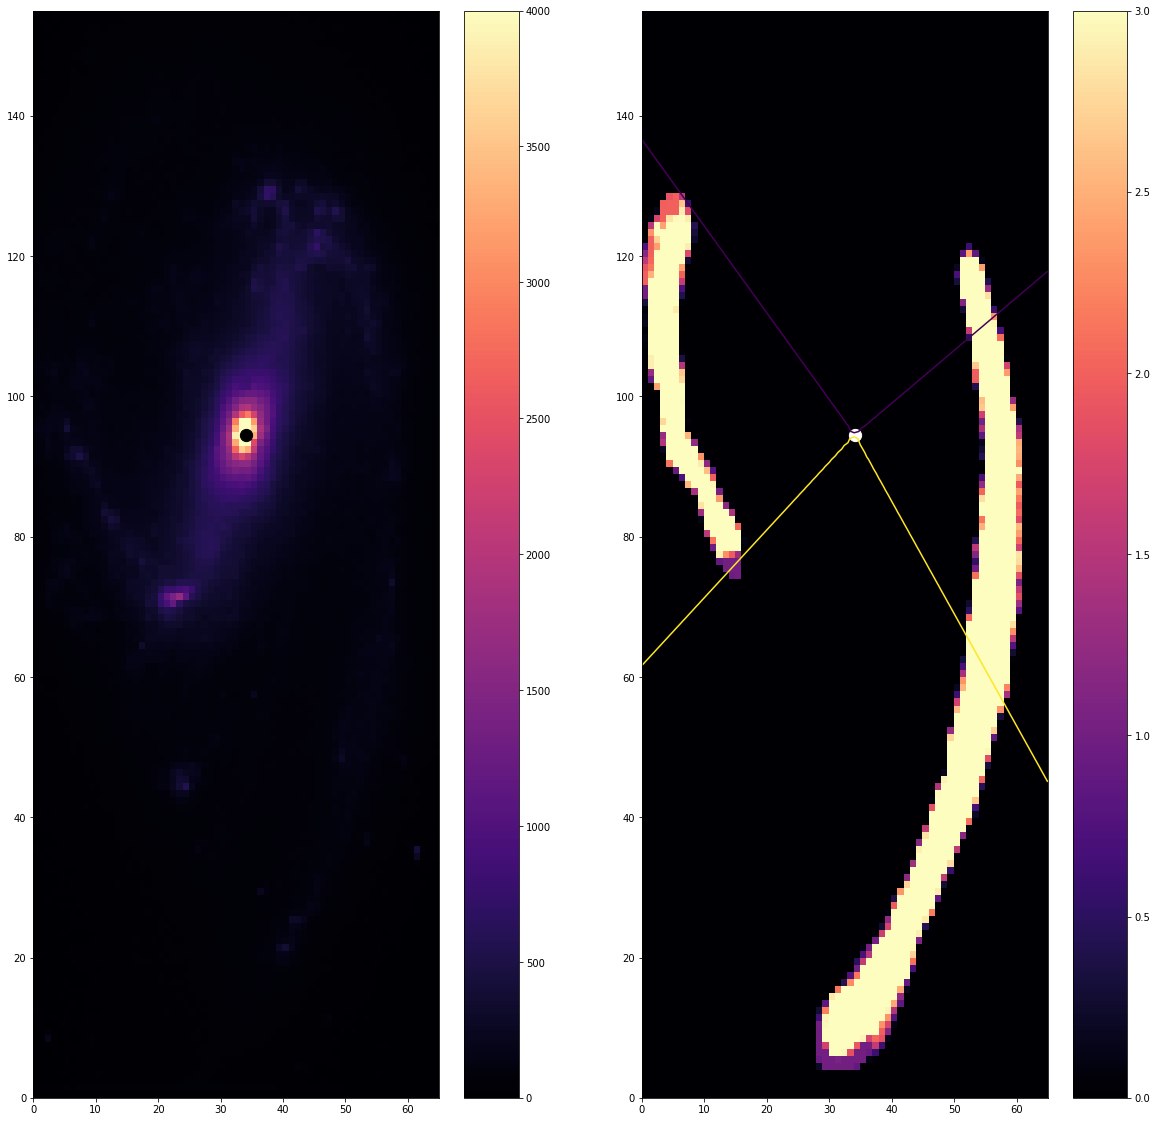

In [38]:
X,Y = np.meshgrid(np.arange(0.,66,1), np.arange(0.,156,1))
X1,Y1 = np.meshgrid(np.arange(0.,100,1), np.arange(0.,200,1))

fig = plt.figure(figsize=[20,20])
plt.subplot(1,2,1)
quadmesh = plt.pcolormesh(X, Y, Sigma_s, cmap='magma')
quadmesh.set_clim(vmin=0., vmax=4000.)
quadmesh.cmap.set_under('white')
plt.colorbar()
plt.scatter(34.06509169 ,94.54027961,[150.], color='black' )

plt.subplot(1,2,2)
new_data_ = new_data[22:-22,29:-5]
quadmesh = plt.pcolormesh(X, Y, new_data_, cmap='magma')
#quadmesh.set_clim(vmin=0., vmax=7000.)
quadmesh.cmap.set_under('white')
plt.colorbar()
plt.scatter(34.06509169 ,94.54027961,[150.], color='white' )
CS = plt.contour(X, Y, phi, levels=[46., 141.], aspect='auto')

In [27]:
mask_stars = new_data[22:-22,29:-5]
np.save('./data/mask_stars.npy', mask_stars)

Теперь попробуем понять какие позиционные углы конца и начала спиралей

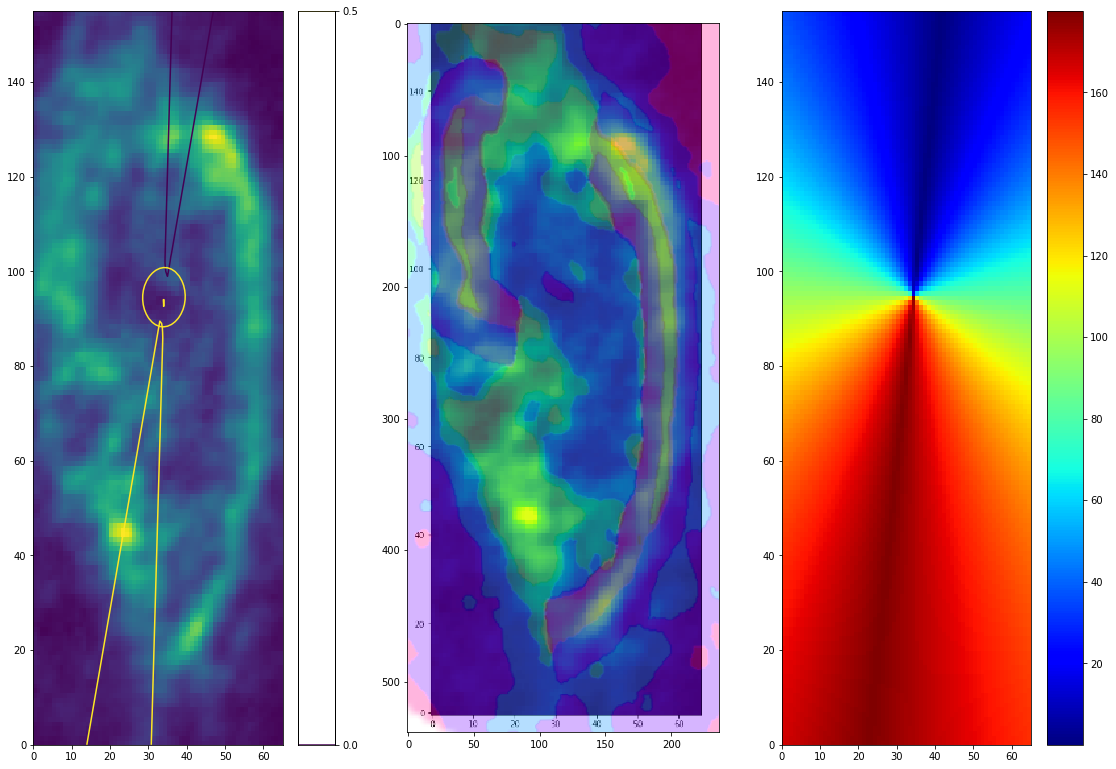

In [14]:
X,Y = np.meshgrid(np.arange(0.,66,1), np.arange(0.,156,1))
plt.figure(figsize=[19, 13.5])
plt.subplot(1,3,1)
quadmesh = plt.pcolormesh(X, Y, Sigma_HI)
CS = plt.contour(X, Y, phi, levels=[5., 175.], aspect='auto')
CS = plt.contour(X, Y, dist_kpc, levels=[0, 0.5], aspect='auto')
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(Im.open('./images/Sigma_HI.png'))
plt.subplot(1,3,3)
quadmesh = plt.pcolormesh(X, Y, phi, cmap='jet')
plt.colorbar()
plt.show()

У нас есть 30 срезов, значит, на каждый из них приходится по 5.6 градусов.
Также нужно перевести из данного масштаба (на 1 пиксель 0.4 пк). После уменьшения разрешения получаем масштаб 0.5 pc/pix. На нашей карте в 1 пикселе 85.9 пк. Следовательно для перевода нужно умножать на 172. 